# Neural network-based filter design for compressive Raman classification of cells

## Imports

In [1]:
import pandas as pd
from os import listdir
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec
import matplotlib.image as mpimg
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['text.usetex'] = False

import seaborn as sns
import numpy as np
from numpy.random import exponential,multinomial,randint,permutation,choice
from numpy.linalg import inv,det
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.cluster import hierarchy
from scipy.stats import multivariate_normal

from os import environ
environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler


import multiprocessing as mp


from random import sample
import pickle
from time import time

np.random.seed(42)
tf.random.set_seed(42)



## Definitions

### Plotting and preprocessing

In [2]:
# define a colorblind-friendly palette
mypalette = ['xkcd:royal blue','xkcd:orange red','xkcd:golden yellow','xkcd:light grey']

def panel_label(ax,label,fontsize=32,xpos=-0.01,ypos=1.1):
    """Adds panel to label"""
    ax.text(xpos,ypos,label,transform=ax.transAxes,
      fontsize=fontsize, fontweight='bold', va='top', ha='right')

def plot_error(spectra_plot,ax,label,color,error='mad'):
    
    if error == 'mad':
        spectra_median = spectra_plot.median(axis=0)
        spectra_dev = (spectra_plot - spectra_median)

        upper = spectra_median + (spectra_dev*(spectra_dev > 0)).sum(axis=0)/(spectra_dev > 0).sum(axis=0)
        lower = spectra_median - (-spectra_dev*(spectra_dev < 0)).sum(axis=0)/(spectra_dev < 0).sum(axis=0)
        
        spectra_stat = spectra_median

    if error == 'sd':
        spectra_mean = spectra_plot.mean(axis=0)
        spectra_dev = (spectra_plot - spectra_mean)

        upper = spectra_mean + np.sqrt(((spectra_dev*(spectra_dev > 0))**2).sum(axis=0)/(spectra_dev > 0).sum(axis=0)) 
        lower = spectra_mean - np.sqrt(((spectra_dev*(spectra_dev < 0))**2).sum(axis=0)/(spectra_dev < 0).sum(axis=0)) 
        
        spectra_stat = spectra_mean

    
    ax.plot(spectra_plot.columns.values, spectra_stat, label=label,lw=3,color=color)
    ax.plot(spectra_plot.columns.values, lower,color=color, alpha=0.1)
    ax.plot(spectra_plot.columns.values, upper,color=color, alpha=0.1)
    ax.fill_between(spectra_plot.columns.values, lower, upper,color=color,alpha=0.2) 
    

def split_data(spectra):
    
    """
    Split data into Raman intensities and meta data
    """
    
    spectra_ctype = spectra.groupby(['ctype']).mean().iloc[:,:-3]
    spectra_ctype.columns = spectra_ctype.columns.astype(float)
    spectra_ctype_std = spectra.groupby(['ctype']).std().iloc[:,:-3]
    spectra_ctype_std.columns = spectra_ctype_std.columns.astype(float)

    spectra_cell = spectra.groupby(['date','rep','cline','ctype','count']).mean()
    spectra_cell.columns = spectra_cell.columns.astype(float)

    meta = spectra.iloc[:,-5:]
    meta['ctype'] = meta['ctype'].astype('category').cat.reorder_categories(['iPSC','NSC','Neuron'])

    meta_cell = spectra_cell.reset_index().iloc[:,:5]
    meta_cell['ctype'] = meta_cell['ctype'].astype('category').cat.reorder_categories(['iPSC','NSC','Neuron'])

    spectra = spectra.iloc[:,:-5]
    spectra.columns = spectra.columns.astype(float)
    
    return spectra, spectra_cell,spectra_ctype,meta, meta_cell

    
def baseline_als(y, lam, p, niter=10):
    
    """
    Baseline removal by asymmetric least squares smoothing introduced by
    PHC Eilers, HFM Boelens (Leiden University Medical Centre Report 1 (1), 5).
    See also: He, S. et al. Baseline correction for Raman spectra using an improved 
    asymmetric least squares method. Anal Methods-uk 6, 4402–4407 (2014).
    
    PARAMETERS
    y: input data
    lam: prefactor of smoothness penalty term (result is smoother if lam is bigger)
    p: asymmetry parameter; weights on deviations are p if deviation is positive, 1-p
        if deviation is negative
    niter: number of iterations of smoothing procedure; weights are updated in each iteration
        
    RETURNS
    z: smoothed input data 
    """
    
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
        
    return z



### SVM and NN

In [3]:

def train_svm(X,y,norm=True,random_state=None):
    """
    Classifies data using SVM. 
    
    PARAMETERS
    X : input data
    y : classes
    
    RETURNS
    accuracy, index of test samples, correct prediction (boolean)
    
    """
    
    if norm:
        X = StandardScaler().fit_transform(X)
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=random_state)

    model = svm.SVC()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)

    return accuracy_score(y_test,y_pred), y_test.index,y_pred==y_test,y_pred,y_test



 
def train_nn(X,y,random_state=None,plot_model=False):

    """
    Classifies data using NN 
    
    PARAMETERS
    X : input data
    y : classes
    
    RETURNS
    accuracy, index of test samples, correct prediction (boolean)
    
    """

    X = StandardScaler().fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y,random_state=random_state)
    
    
    mirrored_strategy = tf.distribute.MirroredStrategy()

    with mirrored_strategy.scope():
        
        model = keras.models.Sequential([
            keras.Input(shape=(X_train.shape[1],)),
            keras.layers.Dense(10,activation="relu"),
            keras.layers.Dense(3,activation="softmax")])    

        model.compile(loss=keras.losses.sparse_categorical_crossentropy,
                      optimizer=keras.optimizers.SGD(learning_rate=0.01),
                      metrics=['accuracy'])

        if plot_model:        
            return model

        history = model.fit(X_train,y_train,epochs=60,validation_split=0.25,
                            verbose=0,batch_size=32,
                            use_multiprocessing=True, workers=8)
        

        y_pred = model.predict(X_test,verbose=0)

        acc = model.evaluate(x=X_test,y=y_test,verbose=0)[1]

    
    return acc,y_test.index,y_test==np.argmax(y_pred,1),np.argmax(y_pred,1),y_test,history


class BinaryWeights(tf.keras.constraints.Constraint):
  """Constrains weight tensors to be binary but non-zero value is variable"""

  def __call__(self,w):
    
    m = tf.reduce_mean(w,axis=0)
    ind = tf.cast(tf.math.greater(w, m),w.dtype)
    m = tf.math.divide(tf.reduce_sum(tf.math.multiply(w,ind),axis=0),tf.math.reduce_sum(ind,axis=0))
    
    return m*tf.cast(tf.math.greater(w, m/2),w.dtype)



def train_nn_filter(X,y,Nfilters=2,constraint='NonNeg',norm='layer',preweights=None,epochs=20,
                    batch_size=32,is_train = None,
                    random_state=None,verbose=0,plot_model=False):

    """
    Classifies spectra using an NN and Nfilters filters
    
    PARAMETERS
    X : input data
    y : classes
    
    RETURNS
    accuracy, index of test samples, correct predictions (boolean), weights, history
    
    """
    
    NBESTOF = 3 #use best out of NBESTOF runs for the same train-test split
    
    if is_train is None:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y,random_state=random_state)
    else:
        X_train = X.loc[is_train,:]
        y_train = y.loc[is_train]
        X_test = X.loc[~is_train,:]
        y_test = y.loc[~is_train]
        
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,stratify=y_train,random_state=random_state)
    

    
    mirrored_strategy = tf.distribute.MirroredStrategy()

    with mirrored_strategy.scope():
    
        if constraint == 'NonNeg':
            const = keras.constraints.NonNeg();
        elif constraint == 'Binary':
            const = BinaryWeights()    

        model = keras.models.Sequential([
            keras.Input(shape=(X_train.shape[1],)),
            keras.layers.Dense(Nfilters,
                             kernel_constraint = const,
                               kernel_initializer='HeUniform',
                               activation="relu"),
            (keras.layers.LayerNormalization() if norm == 'layer' 
             else keras.layers.BatchNormalization()),
            keras.layers.Dense(10,activation="relu",
                               kernel_initializer='HeUniform'), 
            keras.layers.Dense(3,activation="softmax")    
        ])

        model.compile(loss=keras.losses.sparse_categorical_crossentropy,
                      optimizer=keras.optimizers.SGD(learning_rate=0.01),
                      metrics=['accuracy'])

        if not (preweights is None):
            model.set_weights(preweights) 

        if plot_model:
            return model
        
        history = list()
        y_pred = list()
        acc = list()
        allmodels = list()
        
        for i in range(NBESTOF):
            history.append(model.fit(X_train,y_train,epochs=epochs,validation_data=(X_val,y_val),
                                     verbose=verbose,batch_size=batch_size))

            y_pred.append(model.predict(X_test,verbose=0))

            acc.append(model.evaluate(x=X_test,y=y_test,verbose=0)[1])
            
            allmodels.append(model)

        best_ind = np.argmax(acc)
        
    return (acc[best_ind],y_test.index,y_test==np.argmax(y_pred[best_ind],1),np.argmax(y_pred[best_ind],1),
            y_test,allmodels[best_ind].get_weights(), history[best_ind])




### Simulation and BB-based methods

#### Simulation

In [4]:
def simspectra(Nspectra = 3,Nbins = 50,alpha = 3, mixfrac = 0):

    simspec = np.array([exponential(size=Nbins)**alpha for i in range(Nspectra+1)])
    simspec = (simspec.T / simspec.sum(axis=1)).T
    
    return mixfrac*np.repeat(np.expand_dims(simspec[0,:],0),Nspectra,axis=0) + (1-mixfrac)*simspec[1:,:]

def simspectra_wnoise(Nspectra = 3,Nbins = 50,alpha = 3, mixfrac = 0,Nphot=10,Nsample=1000):

    simspec = np.array([exponential(size=Nbins)**alpha for i in range(Nspectra+1)])    
    simspec = (simspec.T / simspec.sum(axis=1)).T
    simspec = mixfrac*np.repeat(np.expand_dims(simspec[0,:],0),Nspectra,axis=0) + (1-mixfrac)*simspec[1:,:]
    rho_mat = np.corrcoef(simspec)
    rho = (rho_mat.sum()-Nspectra)/(Nspectra**2 - Nspectra)

    simspec = np.repeat(simspec,Nsample,axis=0)
    simspec = np.array([ multinomial(Nphot,x.squeeze()) for x in simspec] )
    
    return simspec, rho

#### BB bound for counting noise (multinomial)

In [5]:

def getBB(f,s,Nphot):
    Nfilt = f.shape[0]
    Nspectra = s.shape[0]
    
    mu = np.dot(s,f.T).T
    q = np.sqrt(mu / mu.sum(axis=0))
    A = np.dot(q.T,q)**Nphot

    return (0.5*(A.sum() -  np.diag(A).sum()))/Nspectra

def optfilt(s,Nphot,Nfilt = 3,M=1000):

    Nbins = s.shape[1]

    # randomly initialize filters
    f = randint(2,size=[Nfilt,Nbins])


    allBB = [getBB(f,s,Nphot)]

    for i in range(M):

        fnew = f
        itry = randint(Nfilt)
        jtry = randint(Nbins)

        fnew = f.copy()
        fnew[itry,jtry] = 1 - fnew[itry,jtry] 

        BBnew = getBB(fnew,s,Nphot)

        if BBnew < allBB[-1]:
            allBB.append(BBnew)
            f = fnew.copy()
        else:
            allBB.append(allBB[-1])

    return allBB, f

def optfilt_fixpos(s,Nphot,frac_pos = (1/3),Nfilt = 3,M=1000):

    Nbins = s.shape[1]
    Npos = int(Nbins*frac_pos)

    # randomly initialize filters
    sortspec = np.array(Npos*[1] + (Nbins- Npos)*[0])
    f = np.array([permutation(sortspec) for i in range(Nfilt)])



    allBB = [getBB(f,s,Nphot)]

    for i in range(M):

        fnew = f
        itry = randint(Nfilt)
        j_one = choice(np.where(f[itry,:])[0])
        j_zero = choice(np.where(1-f[itry,:])[0])
        

        fnew = f.copy()
        fnew[itry,j_one] = 0
        fnew[itry,j_zero] = 1
        

        BBnew = getBB(fnew,s,Nphot)

        if BBnew < allBB[-1]:
            allBB.append(BBnew)
            f = fnew.copy()
        else:
            allBB.append(allBB[-1])

    return allBB, f

def getp(f,s):

    if len(s.shape) < 2:
        s = np.expand_dims(s,1).T
    
    mu = np.dot(s,f.T).T
    
    return mu / mu.sum(axis=0)


def geterr(f,s,Nphot,Ntest=10000):

    eps = np.finfo(float).eps
    Nspectra = s.shape[0]

    p = getp(f,s)
    p_nonzero = np.where(p > eps,p,eps)
        
    errprob = list()

    
    for i in range(Nspectra):

        res = list()
        
        for j in range(Ntest):
            n = multinomial(Nphot,p[:,i].squeeze())
            res.append(np.argmax((np.expand_dims(n,1)*np.log(p_nonzero)).sum(axis=0)))


        errprob.append(np.sum([r != i for r in res])/Ntest)
    
    return(np.mean(errprob))


def getacc(f,s,s_exp,y):

    '''returns accuracy!'''
    
    p = getp(f,s)
    
    res = list()

    for i in range(s_exp.shape[0]):
        p_exp = getp(f,s_exp[i,:])
        res.append(np.argmax((p_exp*np.log(p)).sum(axis=0)))
    
    
    return np.sum(np.array(res)==y)/len(res)


def runsimulations(mixfrac,Nphot,Nspectra=3,Nbins=50,Nfilt=3,Nreps=5,Ninit=10):

    allNphot = list()
    allrho = list()
    finalBB = list()
    errs = list()
    efficiency = list()
    
    for i in range(Nreps):
        
        allNphot.append(Nphot)
        
        #create random spectra
        s = simspectra(Nspectra=Nspectra, Nbins=Nbins,mixfrac=mixfrac)

        #calculate correlation
        rho = np.corrcoef(s)
        allrho.append((rho.sum()-Nspectra)/(Nspectra**2 - Nspectra))

        #find optimal filters
        allf = list()
        finalBBs = list()
        
        # start with Ninit different random filters
        for j in range(Ninit):
            allBB, f  = optfilt_fixpos(s,Nphot,frac_pos=(1/3),M=5000)    
            allf.append(f)
            finalBBs.append(allBB[-1])
            
        f = allf[np.argmin(finalBBs)]            
        finalBB.append(np.min(finalBBs))

        # get error
        errs.append(geterr(f,s,Nphot,Ntest=10**6))
        
        efficiency.append(np.mean(np.dot(s,f.T)))
        
                
    return allNphot,allrho, finalBB, errs, efficiency


#### BB bound for normally distributed noise

In [22]:
def getBB_normal(f,s,y,getstats = False):

    Nfilt = f.shape[0]
    labels = set(y)
    Nspectra = max(list(labels))
    
    cov = dict()
    means = dict()
    
    for label in labels:
        
        ind = [yi == label for yi in y]      
        mu = np.dot(s.loc[ind,:],f.T).T
        cov[label] = np.cov(mu)
        means[label] = mu.mean(axis=1)
    
    if getstats:
        return means,cov
    
    else:
        
        BB = 0

        for u in range(Nspectra):
            Pu = np.sum([yi == u for yi in y])/len(y)

            for v in range(u+1,Nspectra):

                Pv = np.sum([yi == v for yi in y])/len(y)

                sumcov = 0.5*(cov[u] + cov[v])
                
                I = (inv(sumcov) if len(sumcov.shape) > 1 else 1/sumcov)
                Ds = (det(sumcov) if len(sumcov.shape) > 1 else sumcov)
                Du = (det(cov[u]) if len(cov[u].shape) > 1 else cov[u])
                Dv = (det(cov[v]) if len(cov[v].shape) > 1 else cov[v])
                
                                    
                BBdist = 0
                BBdist += (1/8)*np.dot(means[u],np.dot(I,means[v]))
                BBdist += (1/2)*np.log(Ds/np.sqrt(Du*Dv))

                BB += np.sqrt(Pu*Pv)*np.exp(-BBdist)


        return BB/Nspectra


    
def optfilt_normal_fixpos(s,y,Nfilt = 3,frac_pos = (1/3), M=1000):

    Nbins = s.shape[1]
    Npos = int(Nbins*frac_pos)

    # randomly initialize filters
    sortspec = np.array(Npos*[1] + (Nbins- Npos)*[0])
    f = np.array([permutation(sortspec) for i in range(Nfilt)])

    allBB = [getBB_normal(f,s,y)]

    for i in range(M):

        fnew = f
        itry = randint(Nfilt)
        j_one = choice(np.where(f[itry,:])[0])
        j_zero = choice(np.where(1-f[itry,:])[0])
        
        fnew = f.copy()
        fnew[itry,j_one] = 0
        fnew[itry,j_zero] = 1

        BBnew = getBB_normal(fnew,s,y)

        if BBnew < allBB[-1]:
            allBB.append(BBnew)
            f = fnew.copy()
        else:
            allBB.append(allBB[-1])

    return allBB, f


def getlogp_normal(f,s_exp,means,cov,y):

    
    if len(s_exp.shape) < 2:
        s_exp = np.expand_dims(s,1).T
    
    mu = np.dot(s_exp,f.T).T
    
    logprob = dict()
    
    for key in means.keys():
        P = np.sum([yi == key for yi in y])/len(y)
        prob = P*multivariate_normal.pdf(mu.T,means[key],cov[key])  
        logprob[key] = np.log(prob)
    
    return logprob 


def getacc_normal(f,s_exp,means,cov,y):

    '''returns accuracy!'''
    
    logprob = pd.DataFrame(getlogp_normal(f,s_exp,means,cov,y)).to_numpy()
    
    ypred = np.argmax(logprob,axis=1)
    
    return np.sum(ypred==y)/len(ypred)




## Parameters

In [7]:
# preprocessing parameters
lam = 1e6
p = 0.1
Nfreq = 443

## Preprocessing

In [ ]:
# folder = './litdata/'
# files = listdir(folder)

# alldatraw = pd.DataFrame()
# allblines = pd.DataFrame()
# alldat = pd.DataFrame()


# colnames = ['freq_' +  str(i) for i in range(Nfreq)]

# count = 0
# for file in files:
    
#     count+=1

#     datraw = pd.read_csv(folder+file,sep='\t')

#     # Crop to fingerprint region
#     datraw = datraw.iloc[:,2:(Nfreq+2)]

#     # Remove rows with zeros        
#     datraw = datraw.loc[(datraw > 0).any(axis=1),:]                

#     # Remove baseline from each spectrum
    
#     blines = datraw.apply(lambda x : baseline_als(x,lam,p),axis=1,result_type='broadcast')
#     dat = datraw - blines

#     # Normalize
#     dat = dat.apply(lambda x : x/sum(x),axis=1)

#     for d in [datraw,blines,dat]:
#         d.columns = colnames
#         d['ctype'] = file.split('_')[0]
#         d['cline'] = file.split('_')[1]
#         d['rep'] = file.split('_')[2][1]
#         d['date'] = file.split('_')[3]
#         d['count'] = file.split('_')[4].split('.')[0]        

#     alldatraw = pd.concat([alldatraw,datraw],axis=0,ignore_index=True)
#     allblines = pd.concat([allblines,blines],axis=0,ignore_index=True)
#     alldat = pd.concat([alldat,dat],axis=0,ignore_index=True)


# # use frequencies as column names
# dat = pd.read_csv(folder+files[0],sep='\t')
# alldat.columns.values[:Nfreq] = dat.columns[2:445].values.astype(float)
# allblines.columns.values[:Nfreq] = dat.columns[2:445].values.astype(float)
# alldatraw.columns.values[:Nfreq] = dat.columns[2:445].values.astype(float)

# # save
# alldatraw.to_csv('raman_fingerprint_raw.csv')    
# allblines.to_csv('raman_fingerprint_baselines.csv')    
# alldat.to_csv('raman_fingerprint_processed.csv')    

### Raw spectra by cell type

In [179]:
spectra = pd.read_csv('raman_fingerprint_raw.csv',index_col=0)
spectra, spectra_cell,spectra_ctype,meta, meta_cell = split_data(spectra)

In [304]:
spectra_mean_df = pd.DataFrame({'log10(means)' : np.log10(spectra.mean(axis=1)), 'cell type' : meta.ctype})
spectra_combined = spectra.copy()
spectra_combined['cell type'] = meta.ctype
spectra_combined = spectra_combined.melt(id_vars=['cell type'],var_name='freq')
spectra_combined['cell type'] = spectra_combined['cell type'].cat.reorder_categories(['iPSC','NSC','Neuron'])

#### Figure 2

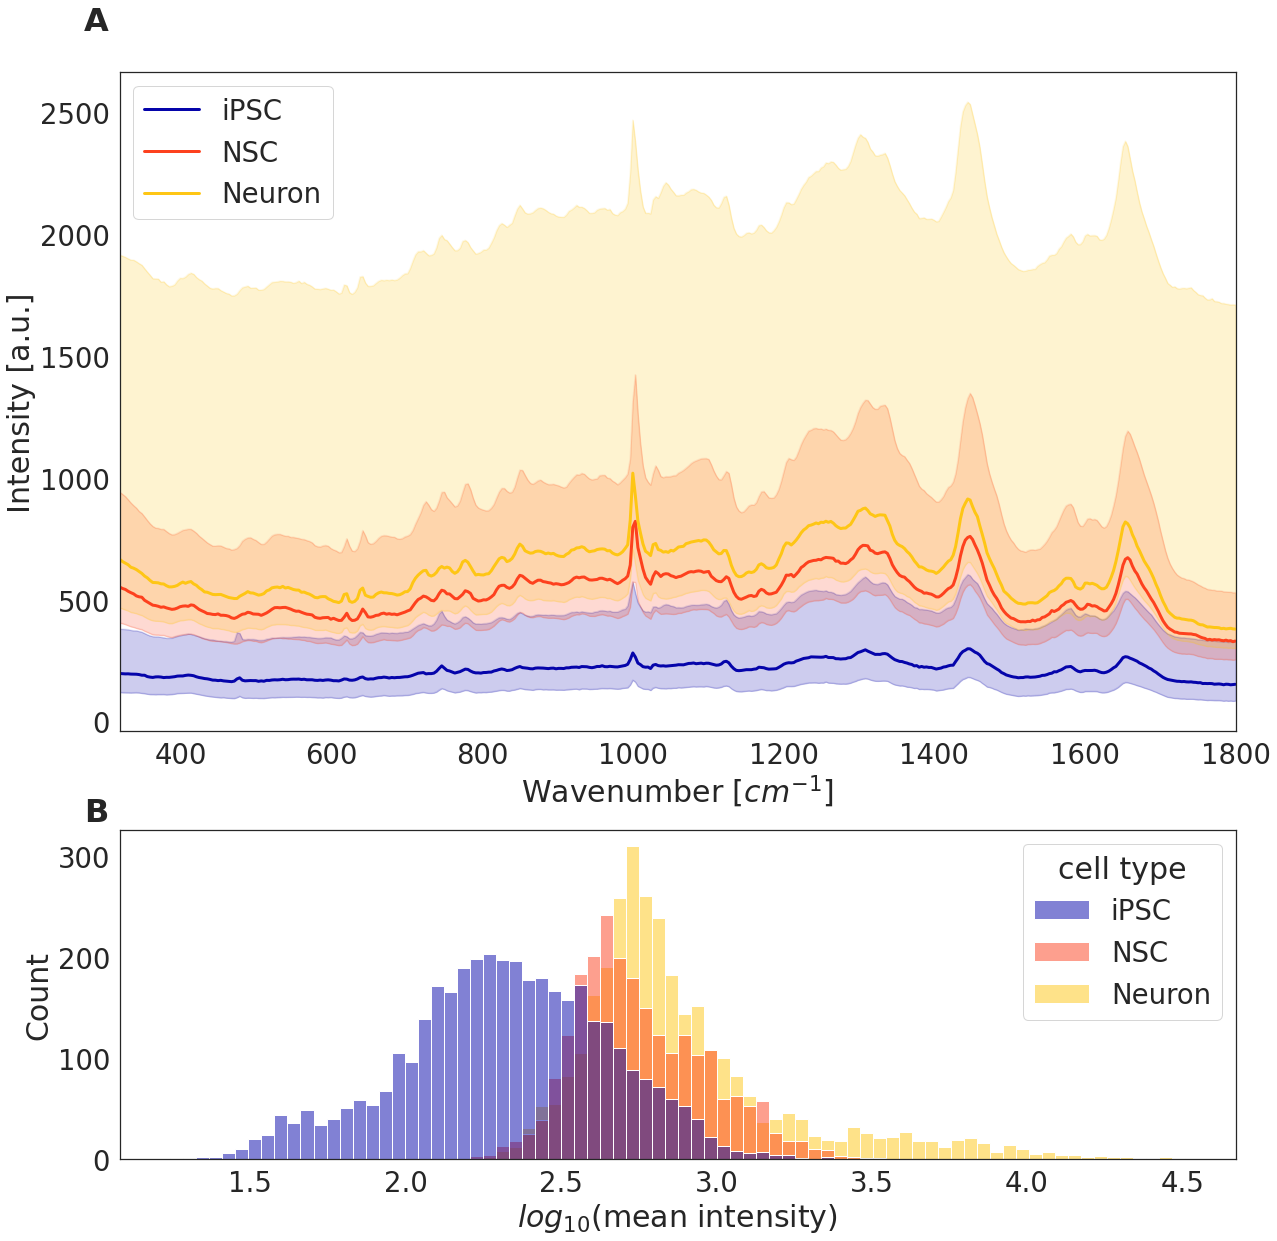

In [305]:
sns.set(style='white',font_scale=2.5)

fig, ax  = plt.subplots(figsize=[20,20],nrows=2,gridspec_kw={'height_ratios': [2, 1]})

panel_label(ax[0],'A')
for ind,ctype in enumerate(['iPSC','NSC','Neuron']):
    plot_error(spectra.loc[meta.ctype==ctype,:],ax[0],ctype,mypalette[ind],error='mad')

ax[0].set_xlabel('Wavenumber $[ cm^{-1} ]$')
ax[0].set_ylabel('Intensity [a.u.]')
ax[0].set_xlim([319,1800])
ax[0].legend()

panel_label(ax[1],'B')
sns.histplot(data=spectra_mean_df,x='log10(means)', hue='cell type',ax=ax[1],palette=mypalette)
ax[1].set_xlabel('$log_{10}$(mean intensity)');

fig.savefig('./figures/Fig2.png')

### Preprocessing example

In [307]:
# load one spectrum as an example
folder = './litdata/'
files = listdir(folder)
dat = pd.read_csv(folder+files[0],sep='\t')

# Crop to fingerprint region
spectrum = dat.iloc[6,2:445]
spectrum.index = spectrum.index.astype(float)

# Calculate baseline
bline = baseline_als(spectrum,lam,p)

# Subtract baseline
spectrum_nobline = spectrum - bline

# Normalize spectrum
spectrum_normalized = spectrum_nobline/sum(spectrum_nobline)


#### Figure S1

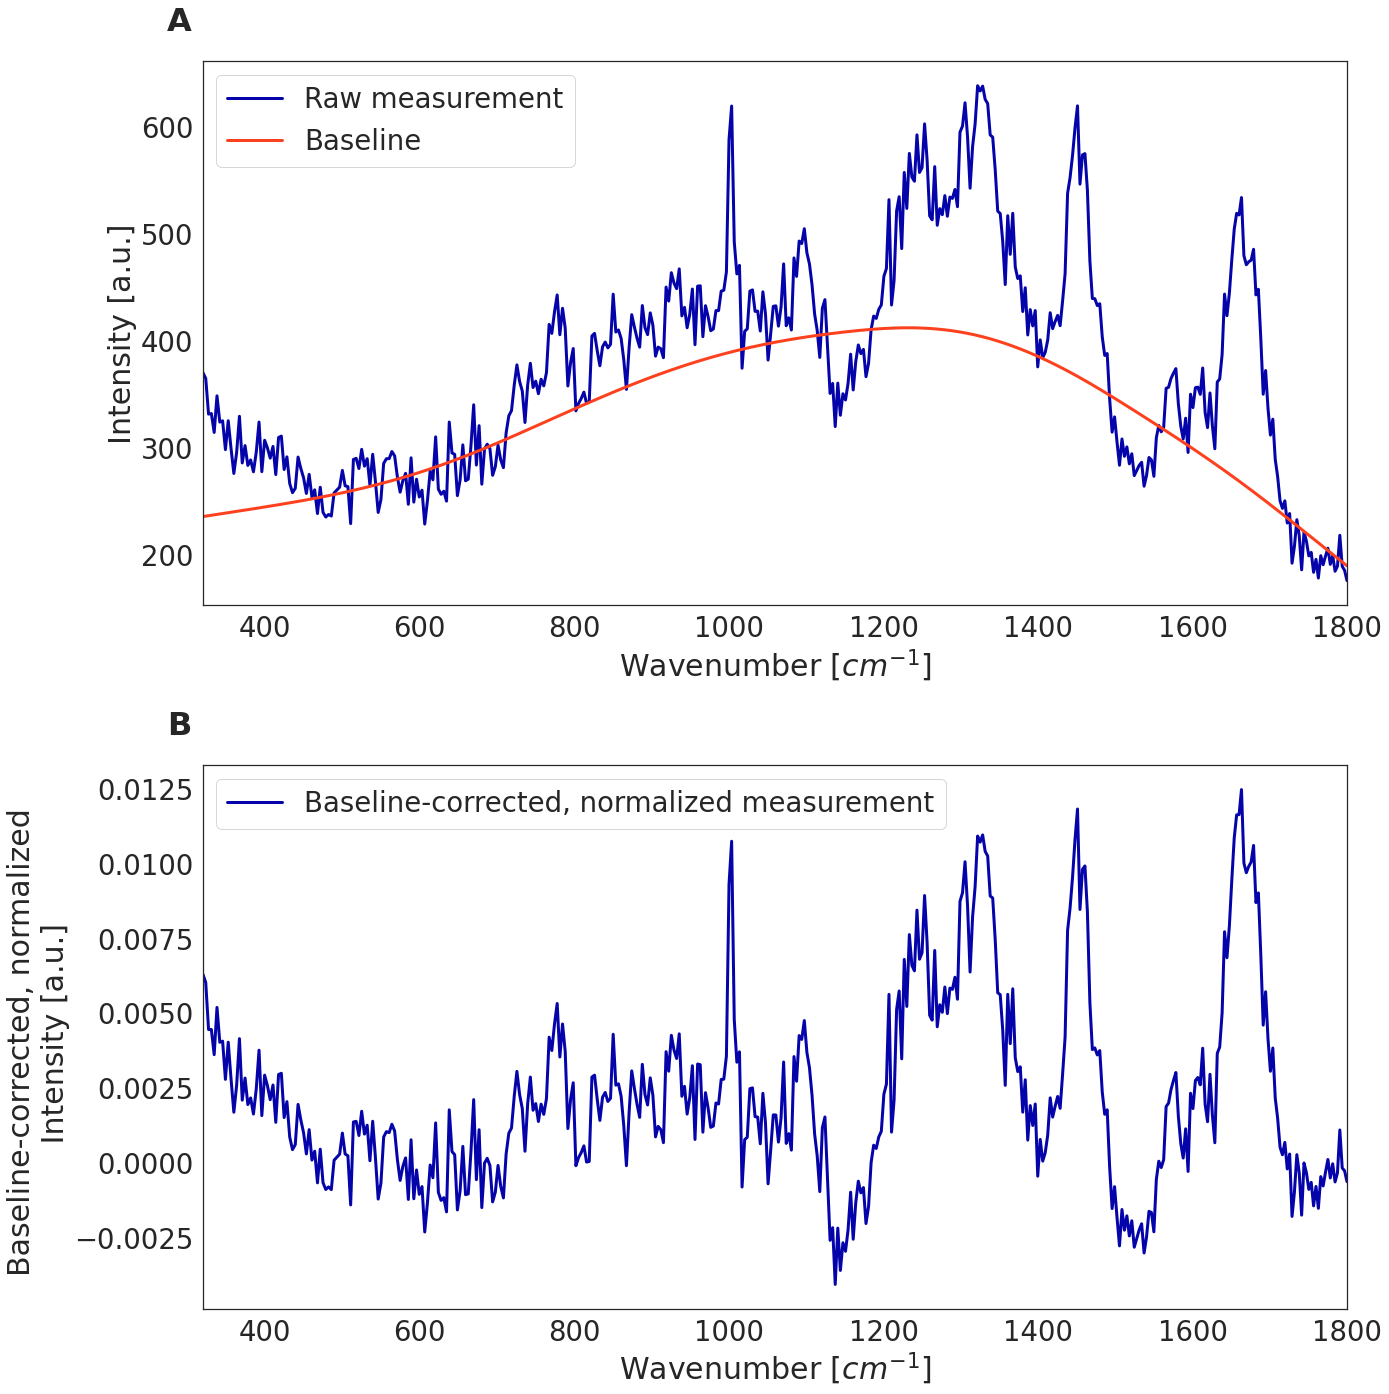

In [308]:
sns.set(style='white',font_scale=2.5)
fig, ax  = plt.subplots(figsize=[20,20],nrows=2)

panel_label(ax[0],'A')
ax[0].plot(spectrum,'-',color='xkcd:royal blue',lw=3,label='Raw measurement')
ax[0].plot(spectrum.index,bline,'-',color='xkcd:orange red',lw=3,label='Baseline')
ax[0].set_xlabel('Wavenumber $[ cm^{-1} ]$')
ax[0].set_ylabel('Intensity [a.u.]')
ax[0].set_xlim([319,1800])
ax[0].legend();

panel_label(ax[1],'B')
ax[1].plot(spectrum_normalized,'-',color='xkcd:royal blue',lw=3,
           label='Baseline-corrected, normalized measurement')
ax[1].set_xlabel('Wavenumber $[ cm^{-1} ]$')
ax[1].set_ylabel('Baseline-corrected, normalized \n Intensity [a.u.]',wrap=True)
ax[1].set_xlim([319,1800])
ax[1].legend();
fig.tight_layout()
fig.savefig('./figures/FigS1.png')

### Processed spectra by cell type

In [309]:
spectra = pd.read_csv('raman_fingerprint_processed.csv',index_col=0)
spectra, spectra_cell,spectra_ctype,meta, meta_cell = split_data(spectra)

In [311]:
# combine spectra and change to long form for visualization
spectra_combined = spectra.copy()
spectra_combined['cell type'] = meta.ctype
spectra_combined = spectra_combined.melt(id_vars=['cell type'],var_name='freq')
spectra_combined['cell type'] = spectra_combined['cell type'].cat.reorder_categories(['iPSC','NSC','Neuron'])

#### Figure S2

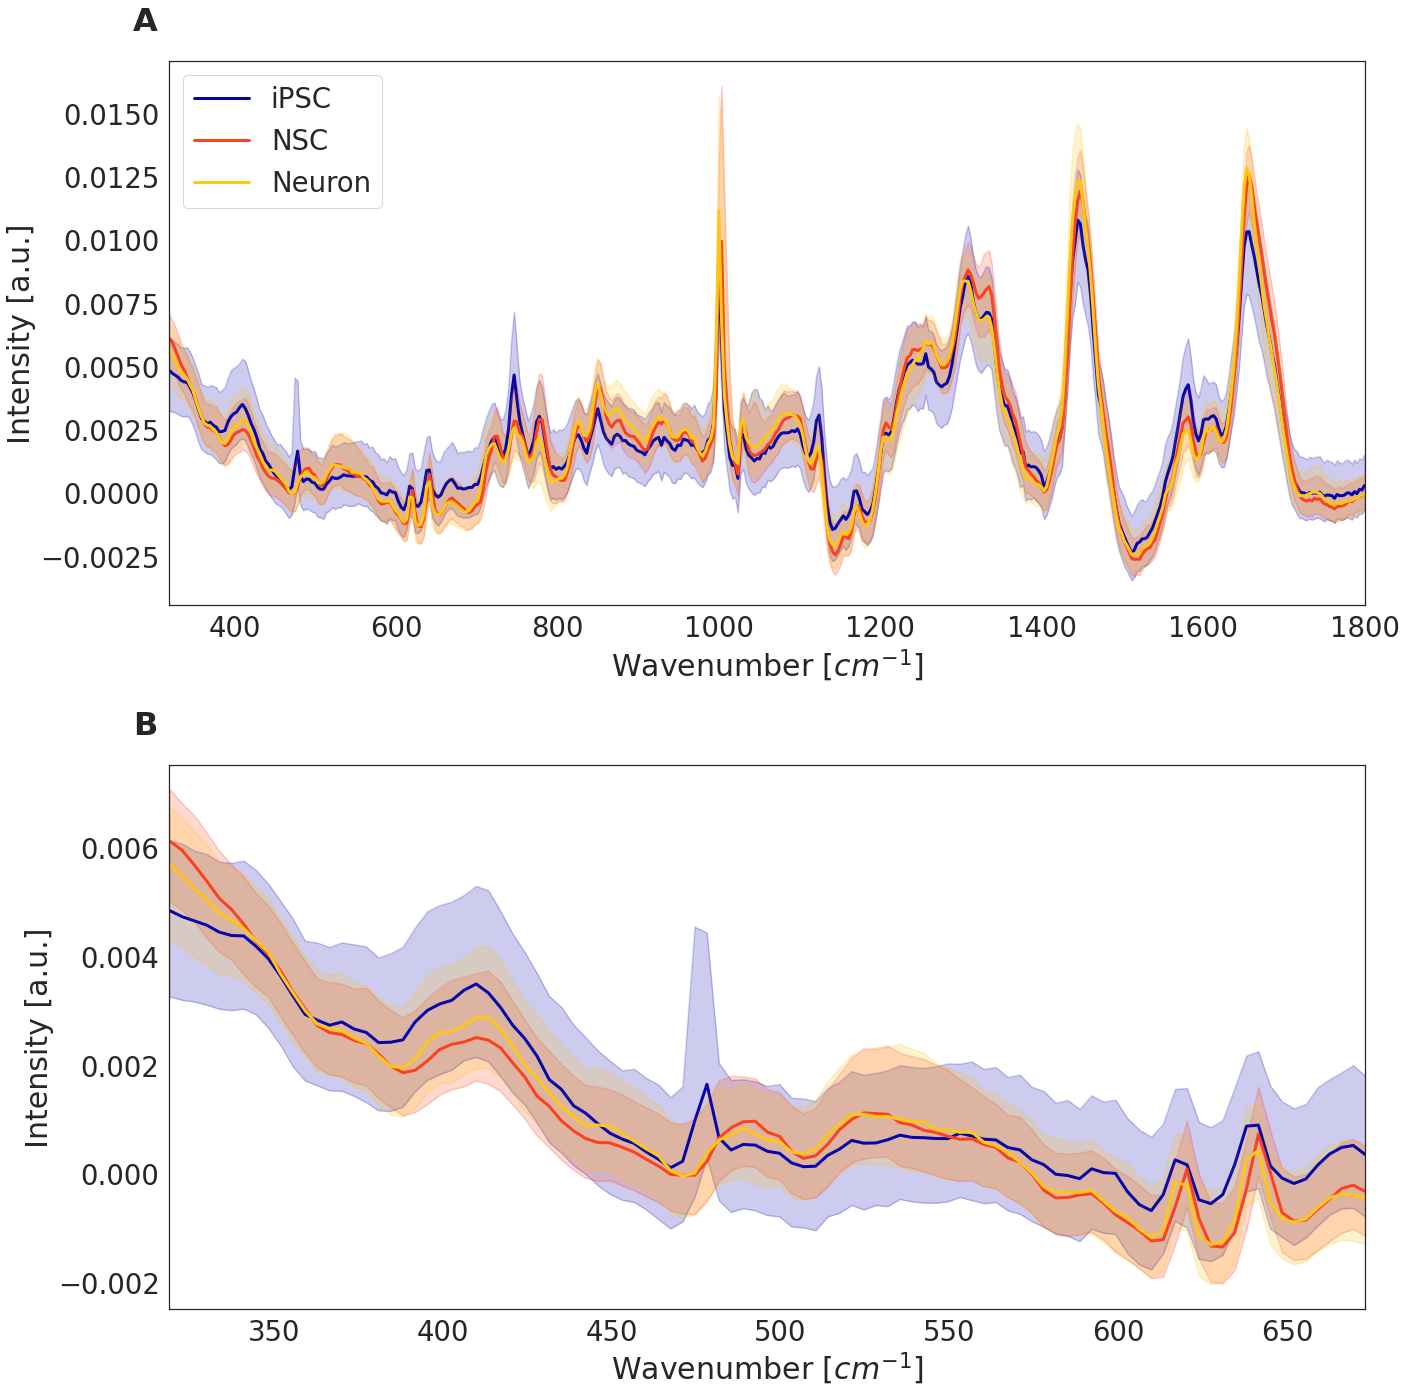

In [312]:
sns.set(style='white',font_scale=2.5)
fig, ax  = plt.subplots(figsize=[20,20],nrows=2)

panel_label(ax[0],'A')
for ind,ctype in enumerate(['iPSC','NSC','Neuron']):
    plot_error(spectra.loc[meta.ctype==ctype,:],ax[0],ctype,mypalette[ind],error='mad')

ax[0].set_xlabel('Wavenumber $[ cm^{-1} ]$')
ax[0].set_ylabel('Intensity [a.u.]')
ax[0].set_xlim([319,1800])
ax[0].legend()

panel_label(ax[1],'B')
for ind,ctype in enumerate(['iPSC','NSC','Neuron']):
    plot_error(spectra.loc[meta.ctype==ctype,:].iloc[:,:100],ax[1],ctype,mypalette[ind],error='mad')
    
ax[1].set_xlabel('Wavenumber $[ cm^{-1} ]$')
ax[1].set_ylabel('Intensity [a.u.]')
ax[1].set_xlim([319,673])
fig.tight_layout()
fig.savefig('./figures/FigS2.png')

## Standard classification

### Classification using complete spectra

In [138]:
spectra = pd.read_csv('raman_fingerprint_processed.csv',index_col=0)
spectra, spectra_cell,spectra_ctype,meta, meta_cell = split_data(spectra)

# code cell types as integers
y = meta['ctype'].map({'iPSC' : 0 , 'NSC' : 1, 'Neuron' :2}).astype('uint8')

# base accuracy: naive model always picking the must abundant class
base_acc = max(meta.groupby(by='ctype').count().iloc[:,0])/meta.shape[0]

#### Setup PCA and tSNE

In [39]:
pca = PCA(n_components=10).fit_transform(spectra)

pca_df = pd.DataFrame(pca[:,:2])
pca_df.columns = ['PC1','PC2']
pca_df['cell type'] = meta['ctype']

tsne_map = TSNE().fit_transform(pca)
tsne_map_df = pd.DataFrame(tsne_map)
tsne_map_df.columns = ['tSNE1','tSNE2']
tsne_map_df['cell type'] = meta['ctype']


/home/ssemrau/anaconda3/envs/RAMAN/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ssemrau/anaconda3/envs/RAMAN/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


#### Training

In [99]:
np.random.seed(42)
tf.random.set_seed(42)

Nreps = 5

all_acc_svm = list()
all_acc_nn = list()
all_ypred_svm = list()
all_ytest_svm = list()
all_ypred_nn = list()
all_ytest_nn = list()


for i in range(Nreps):
np.random.seed(42)
tf.random.set_seed(42)

    acc_svm,index_svm,is_correct_svm,y_pred_svm,y_test_svm = train_svm(spectra,y)
    acc_nn,index_nn,is_correct_nn,y_pred_nn,y_test_nn,history = train_nn(spectra,y)
    
    all_acc_svm.append(acc_svm)
    all_acc_nn.append(acc_nn)
    
    all_ypred_svm += list(y_pred_svm)
    all_ytest_svm += list(y_test_svm)
    all_ypred_nn  += list(y_pred_nn)
    all_ytest_nn += list(y_test_nn)
    

print([np.mean(all_acc_svm),np.mean(all_acc_nn)])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
[0.9145005370569279, 0.8974221229553223]


#### Figure S3

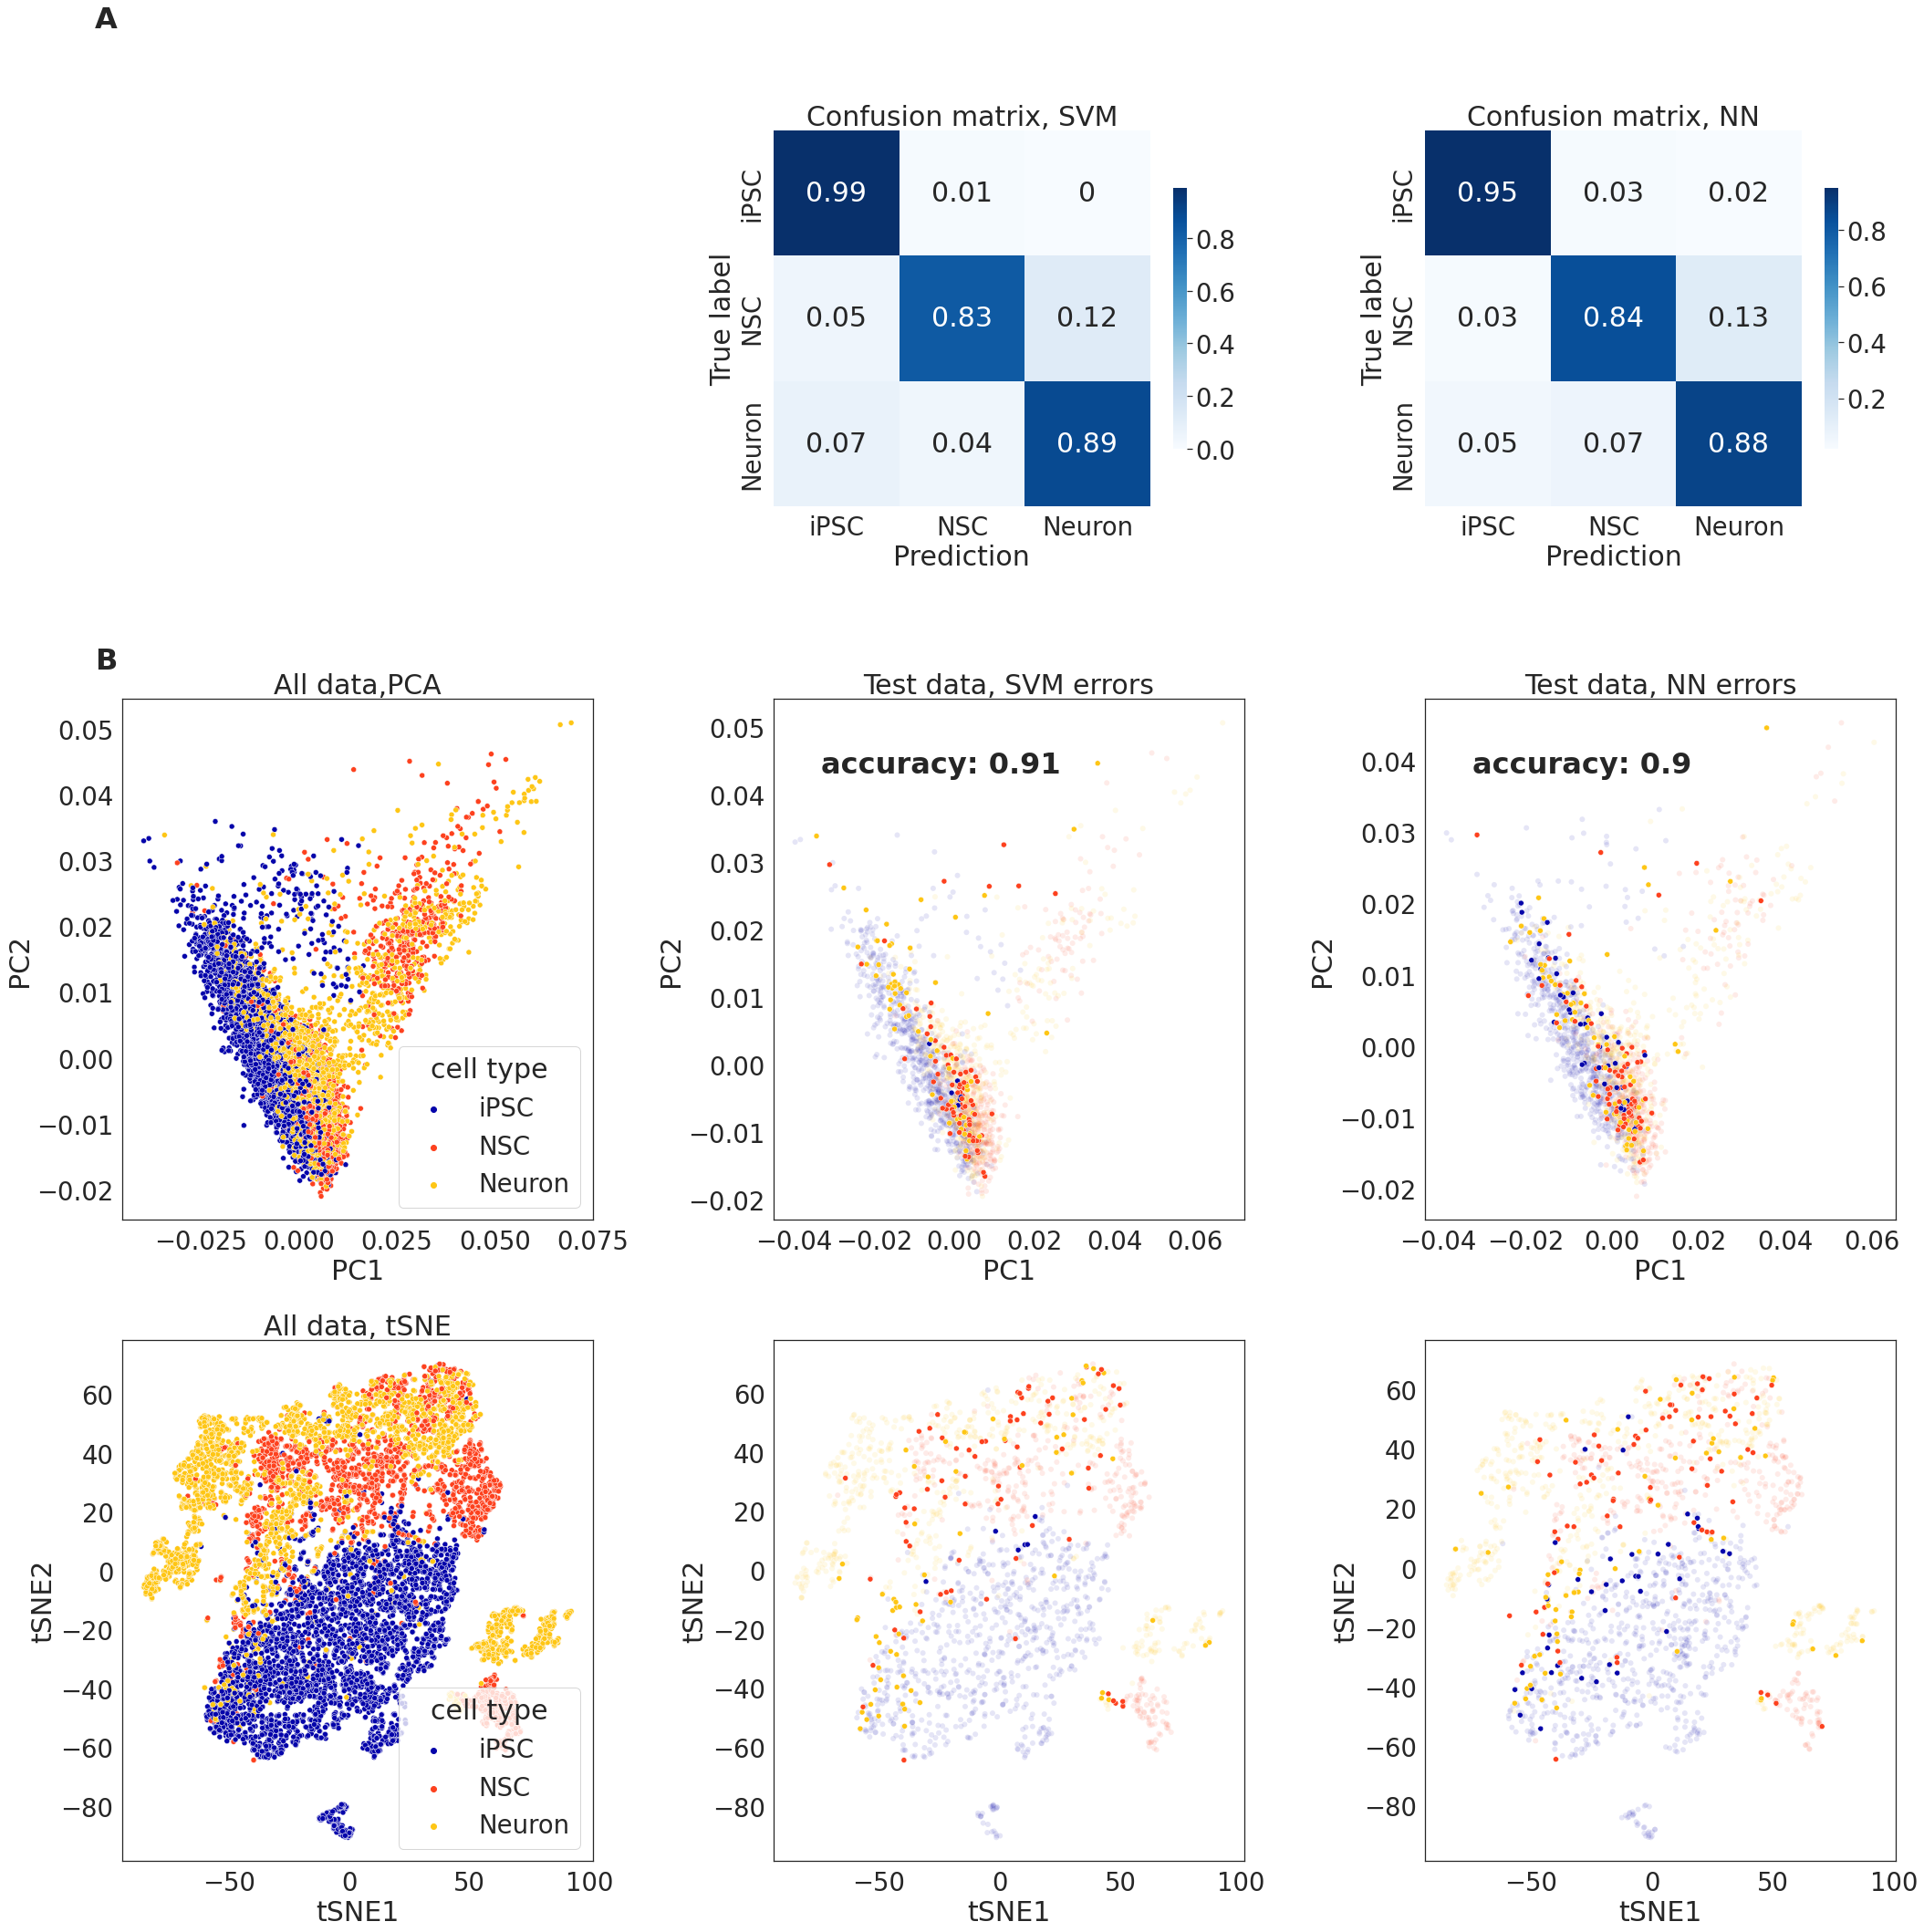

In [102]:
sns.set(style='white',font_scale=2.5)

fig,ax  = plt.subplots(figsize=[30,30],nrows=3,ncols=3)
# gridspec_kw={'height_ratios': [2, 1]}

panel_label(ax[0,0],'A')

conf_svm = np.round(confusion_matrix(all_ytest_svm,all_ypred_svm,labels = [0,1,2],normalize='true'),2)
conf_nn = np.round(confusion_matrix(all_ytest_nn,all_ypred_nn,labels = [0,1,2],normalize='true'),2)


s = sns.heatmap(conf_svm,xticklabels = ['iPSC','NSC','Neuron'],
            yticklabels = ['iPSC','NSC','Neuron'],cbar_kws={"shrink": 0.5},
           square=True,cmap="Blues",annot=True,ax=ax[0,1])

s.set(xlabel='Prediction', ylabel='True label')


ax[0,1].set_title('Confusion matrix, SVM');


s = sns.heatmap(conf_nn,xticklabels = ['iPSC','NSC','Neuron'],
            yticklabels = ['iPSC','NSC','Neuron'],cbar_kws={"shrink": 0.5},
           square=True,cmap="Blues",annot=True,ax=ax[0,2])

s.set(xlabel='Prediction', ylabel='True label')

ax[0,2].set_title('Confusion matrix, NN');

ax[0,0].axis('off')
# ax[0,0].get_xaxis().set_visible(False)
# ax[0,0].get_yaxis().set_visible(False)


# show dim reduction

sns.scatterplot(data=pca_df,x='PC1',y='PC2',hue='cell type',ax=ax[1,0],palette = mypalette[:3]);
ax[1,0].set_title('All data,PCA')

sns.scatterplot(data=tsne_map_df,x='tSNE1',y='tSNE2',hue='cell type',palette = mypalette[:3],ax=ax[2,0])
ax[2,0].set_title('All data, tSNE')

# wrong predictions SVM

panel_label(ax[1,0],'B')


pca_test_df = pca_df.loc[index_svm,:]



sns.scatterplot(data=pca_test_df.loc[is_correct_svm,:],x='PC1',y='PC2',hue='cell type',ax=ax[1,1],palette = mypalette[:3],alpha=0.1)
sns.scatterplot(data=pca_test_df.loc[~is_correct_svm,:],x='PC1',y='PC2',hue='cell type',ax=ax[1,1],palette = mypalette[:3],alpha=1)

ax[1,1].set_title('Test data, SVM errors');
ax[1,1].text(0.1, 0.9,'accuracy: '+str(np.round(np.mean(all_acc_svm),2)),
                        transform=ax[1,1].transAxes,
                        fontsize=32, fontweight='bold', va='top', ha='left')

ax[1,1].get_legend().remove()

tsne_map_test_df = tsne_map_df.loc[index_svm,:]

sns.scatterplot(data=tsne_map_test_df.loc[is_correct_svm,:],x='tSNE1',y='tSNE2',hue='cell type',
                                                            palette = mypalette[:3],ax=ax[2,1],alpha=0.1)
sns.scatterplot(data=tsne_map_test_df.loc[~is_correct_svm,:],x='tSNE1',y='tSNE2',hue='cell type',
                                                            palette = mypalette[:3],ax=ax[2,1],alpha=1)


ax[2,1].get_legend().remove()

# wrong predictions NN

pca_test_df = pca_df.loc[index_nn,:]


sns.scatterplot(data=pca_test_df.loc[is_correct_nn,:],x='PC1',y='PC2',hue='cell type',ax=ax[1,2],palette = mypalette[:3],alpha=0.1)
sns.scatterplot(data=pca_test_df.loc[~is_correct_nn,:],x='PC1',y='PC2',hue='cell type',ax=ax[1,2],palette = mypalette[:3],alpha=1)

ax[1,2].set_title('Test data, NN errors');
ax[1,2].text(0.1, 0.9,'accuracy: '+str(np.round(np.mean(all_acc_nn),2)),
                         transform=ax[1,2].transAxes,
                         fontsize=32, fontweight='bold', va='top', ha='left')

ax[1,2].get_legend().remove()

tsne_map_test_df = tsne_map_df.loc[index_nn,:]

sns.scatterplot(data=tsne_map_test_df.loc[is_correct_nn,:],x='tSNE1',y='tSNE2',hue='cell type',
                                                palette = mypalette[:3],ax=ax[2,2],alpha=0.1)

sns.scatterplot(data=tsne_map_test_df.loc[~is_correct_nn,:],x='tSNE1',y='tSNE2',hue='cell type',
                                                palette = mypalette[:3],ax=ax[2,2],alpha=1)


ax[2,2].get_legend().remove()

plt.tight_layout()

fig.savefig('./figures/FigS3.png')


**Figure S3**

### Classification based on subsetted or binned spectra 

#### Subsetted spectra

##### Selection of wavenumbers

In [140]:
# fraction of wavenumbers with highest variability
tops = [0.001,0.0025,0.005,0.01,0.02,0.03,0.04,0.05,0.1,0.2,0.5,1]

In [141]:
std = spectra_ctype.std(axis=0)

top_freqs_df = pd.DataFrame(columns = ['top','freq'])

for top in tops:
    q = np.quantile(std,1-top)
    top_freqs = std[std >= q].index.values #[np.int(s.split('_')[1]) for s in ]

    top_freqs_df = pd.concat([top_freqs_df,
                              pd.DataFrame( {'top' : top*np.ones(len(top_freqs)), 'freq' : top_freqs})])


##### Figure S4

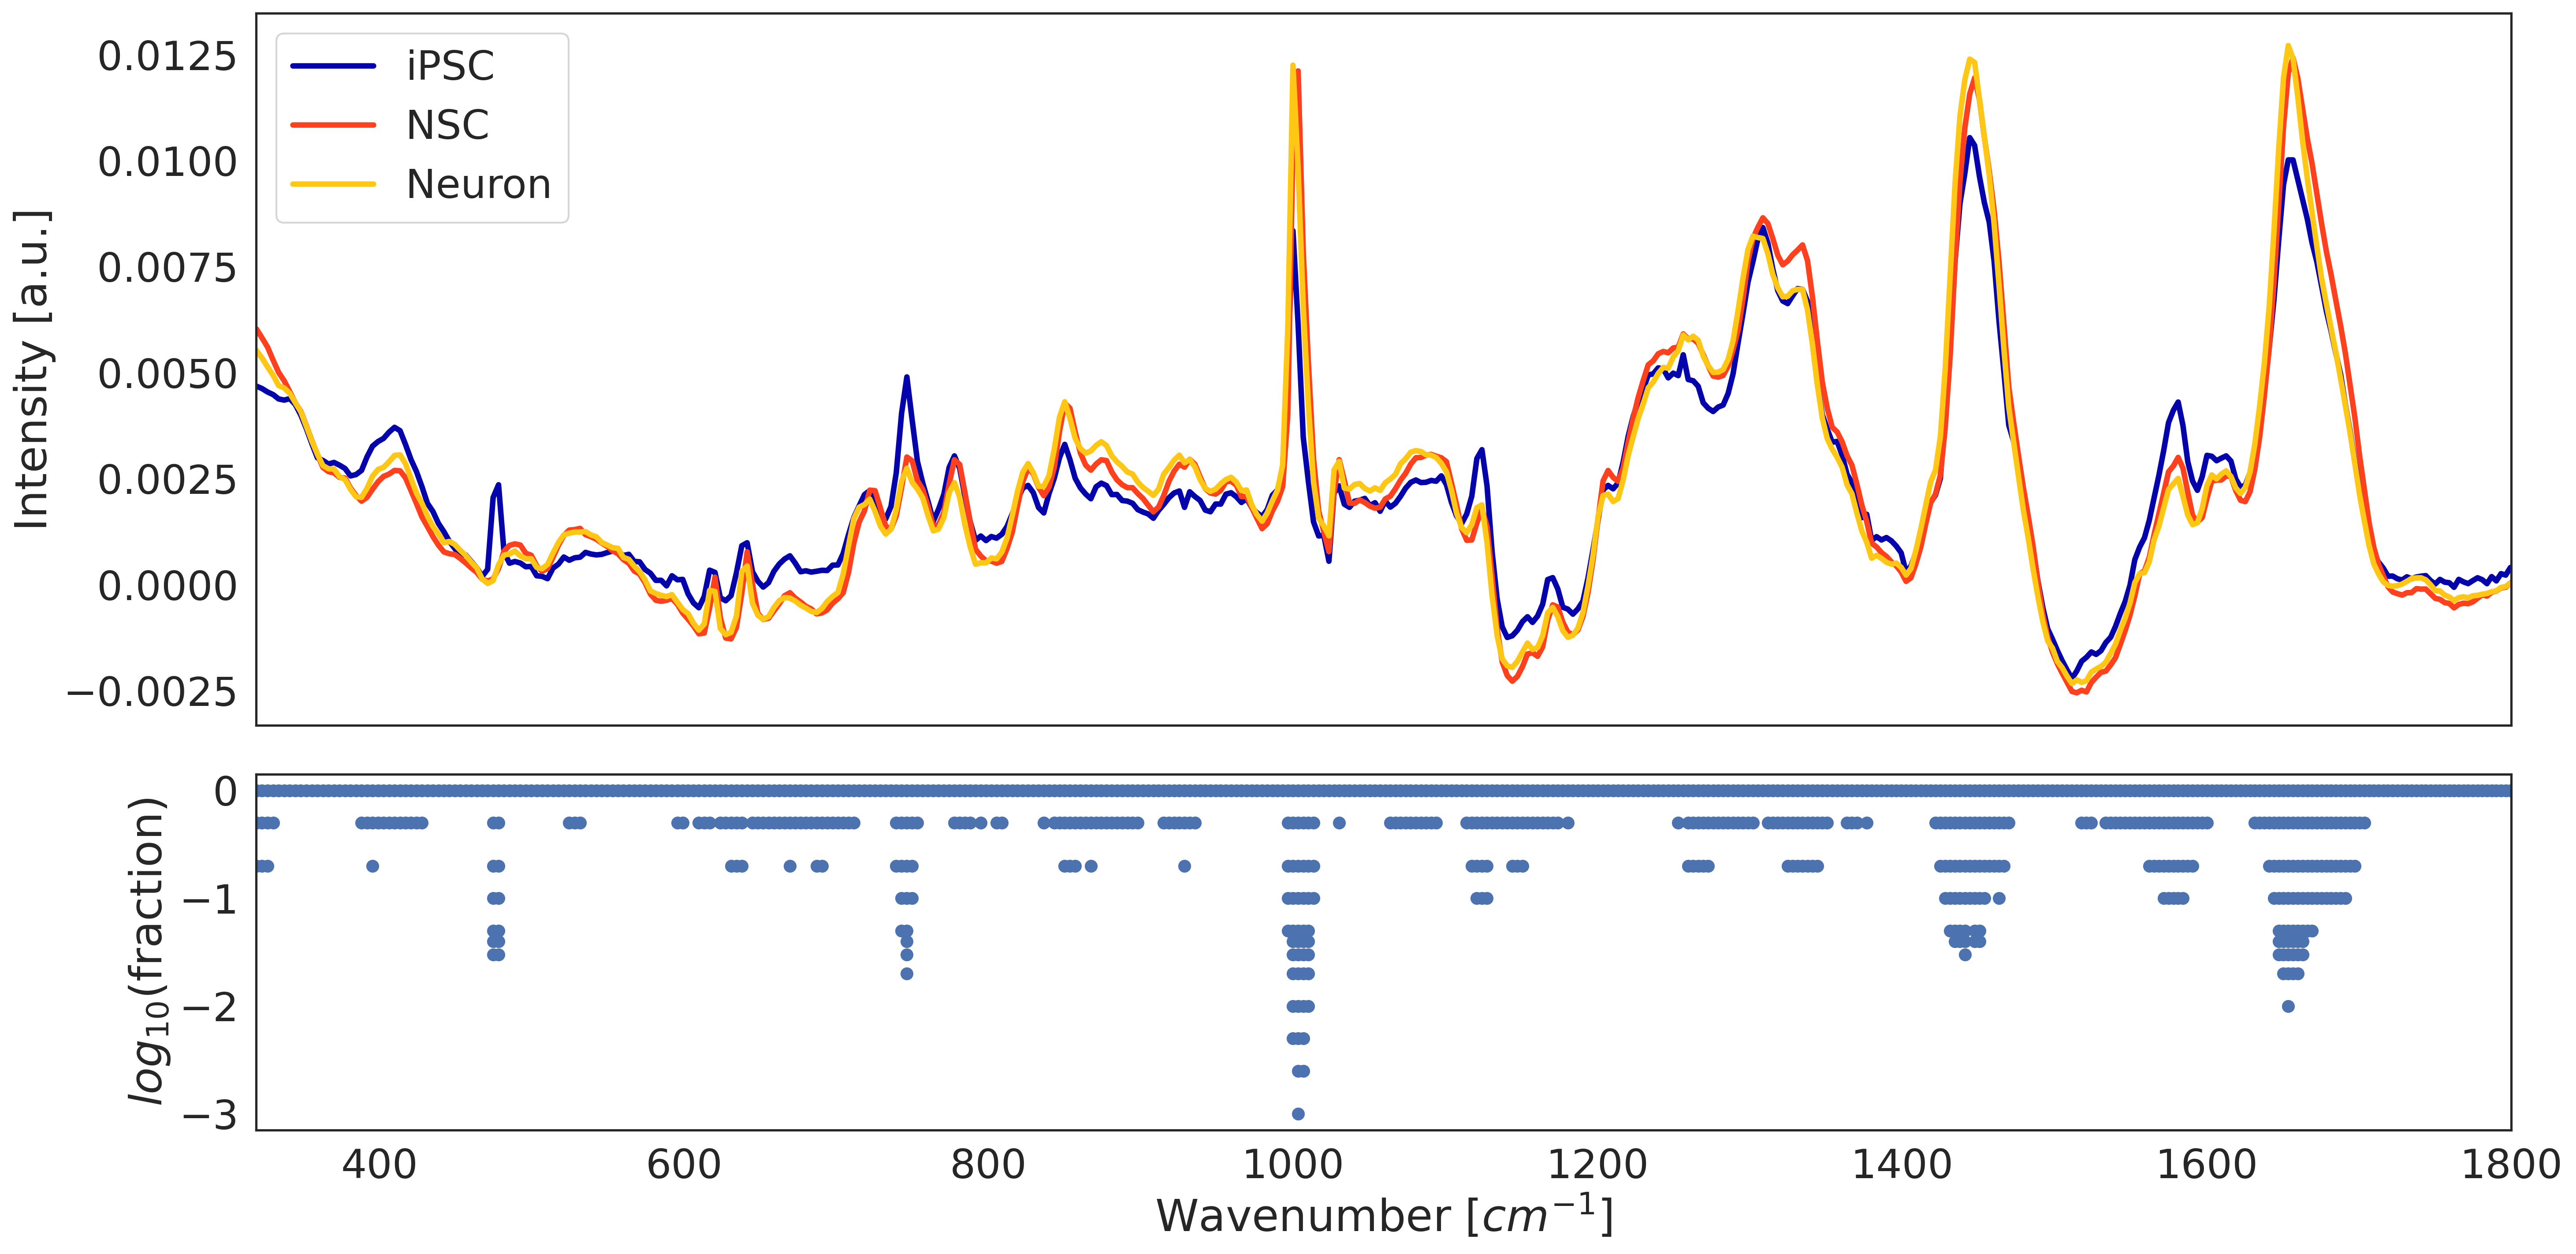

In [142]:
sns.set(style='white',font_scale=2)

fig, ax  = plt.subplots(figsize=[20,10],nrows=2,sharex=True,gridspec_kw={'height_ratios': [2, 1]})

ax[0].plot(spectra_ctype.loc['iPSC',:],'-',color=mypalette[0],lw=3,label='iPSC');
ax[0].plot(spectra_ctype.loc['NSC',:],'-',color=mypalette[1],lw=3,label='NSC');
ax[0].plot(spectra_ctype.loc['Neuron',:],'-',color=mypalette[2],lw=3,label='Neuron');
ax[0].set_xlim([319,1800])
ax[0].set_ylabel('Intensity [a.u.]')
ax[0].legend()

ax[1].plot(top_freqs_df['freq'],np.log10(top_freqs_df['top']),'o')
ax[1].set_xlim([319,1800])
ax[1].set_xlabel('Wavenumber $[ cm^{-1} ]$')
ax[1].set_ylabel('$log_{10}$(fraction)')

plt.tight_layout()

fig.savefig('./figures/FigS4.png')

##### Training

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

Nreps = 5 #number of runs per condition

std = spectra_ctype.std(axis=0) 

mod = ['svm','nn']
freqchoice = ['best','random']

acc = { m : {f : {top : list() for top in tops} for f in freqchoice} for m in mod}

allNtop = list()


for top in tops:
    
    print(top)
    
    # choose frequencies with most variable signal
    q = np.quantile(std,1-top)
    is_top_freq = (std >= q).values
    Ntop = sum(is_top_freq)
    allNtop.append(Ntop)
    
    for m in mod:
        for f in freqchoice:
            
            if f == 'best':
                X_top = spectra.loc[:,is_top_freq]
            else:
                X_top = spectra.sample(n=Ntop,axis='columns')
            
            for rep in range(Nreps):
                
                if m == 'svm':
                    acc_model, test_index, is_correct = train_svm(X_top,y)
                else:
                    acc_model, test_index, is_correct, history = train_nn(X_top,y)
            
                acc[m][f][top].append(acc_model)

with open('./results/acc_svm_nn_subset.pkl', 'wb') as f:  
    pickle.dump(acc, f)
    
with open('./results/allNtop.pkl', 'wb') as f:  
    pickle.dump(allNtop, f)

#### Binning and averaging

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

Nreps = 5 #number of runs per condition

# size of frequency interval
deltas = [1,5,10,20,40,80,100,200,400]

acc_bin = { m : {delta : list() for delta in deltas} for m in mod}

allNbin = list()

for delta in deltas:

    print(delta)

    
    # average over frequency bands for individual spectra        
    spec_mean = pd.DataFrame()

    for i in range(int(spectra.shape[1]/delta)):
        spec_mean = pd.concat((spec_mean,spectra.iloc[:,delta*i:min([spectra.shape[1],delta*(i+1)])].mean(axis=1)),axis=1)

    
    for rep in range(Nreps):
        acc_model, test_index, is_correct = train_svm(spec_mean,y)
        acc_bin['svm'][delta].append(acc_model)
        acc_model, test_index, is_correct,history = train_nn(spec_mean,y)
        acc_bin['nn'][delta].append(acc_model)
            
    allNbin.append(spec_mean.shape[1])

    


with open('./results/acc_svm_nn_binned.pkl', 'wb') as f:  
    pickle.dump(acc_bin, f)


### Comparison of approaches

In [18]:
tops = [0.001,0.0025,0.005,0.01,0.02,0.03,0.04,0.05,0.1,0.2,0.5,1]
mod = ['svm','nn']
freqchoice = ['best','random']
deltas = [1,5,10,20,40,80,100,200,400]

allNtop = list()


file = open('./results/acc_svm_nn_subset.pkl','rb')
acc = pickle.load(file)
file.close()

file = open('./results/acc_svm_nn_binned.pkl','rb')
acc_bin = pickle.load(file)
file.close()

file = open('./results/allNtop.pkl','rb')
allNtop = pickle.load(file)
file.close()

file = open('./results/allNbin.pkl','rb')
allNbin = pickle.load(file)
file.close()


acc_mean = { m : {f : {top : np.mean(acc[m][f][top]) for top in tops} for f in freqchoice} for m in mod}

acc_mean_df = pd.DataFrame({'SVM,best' : acc_mean['svm']['best'].values(), 'SVM,random' : acc_mean['svm']['random'].values(),
          'NN,best' : acc_mean['nn']['best'].values(), 'NN,random' : acc_mean['nn']['random'].values()},index=allNtop)


acc_bin_mean = { m : {delta : np.mean(acc_bin[m][delta]) for delta in deltas} for m in mod}


acc_bin_mean_df = pd.DataFrame({'SVM,binned' : acc_bin_mean['svm'].values(), 
          'NN,binned' : acc_bin_mean['nn'].values()},index=allNbin)


In [19]:
all_acc_df = pd.concat([acc_mean_df,acc_bin_mean_df]).reset_index().sort_values(by='index').melt(id_vars=['index'])
# all_acc_df.iloc[:,0] = np.log10(all_acc_df.iloc[:,0]) 
all_acc_df.columns = ['N_measurements','Approach','Accuracy']
all_acc_df['model'] = [s.split(',')[0] for s in all_acc_df.Approach]
all_acc_df['selection'] = [s.split(',')[1] for s in all_acc_df.Approach]
all_acc_df.drop('Approach',axis=1,inplace=True)

#### Figure S5

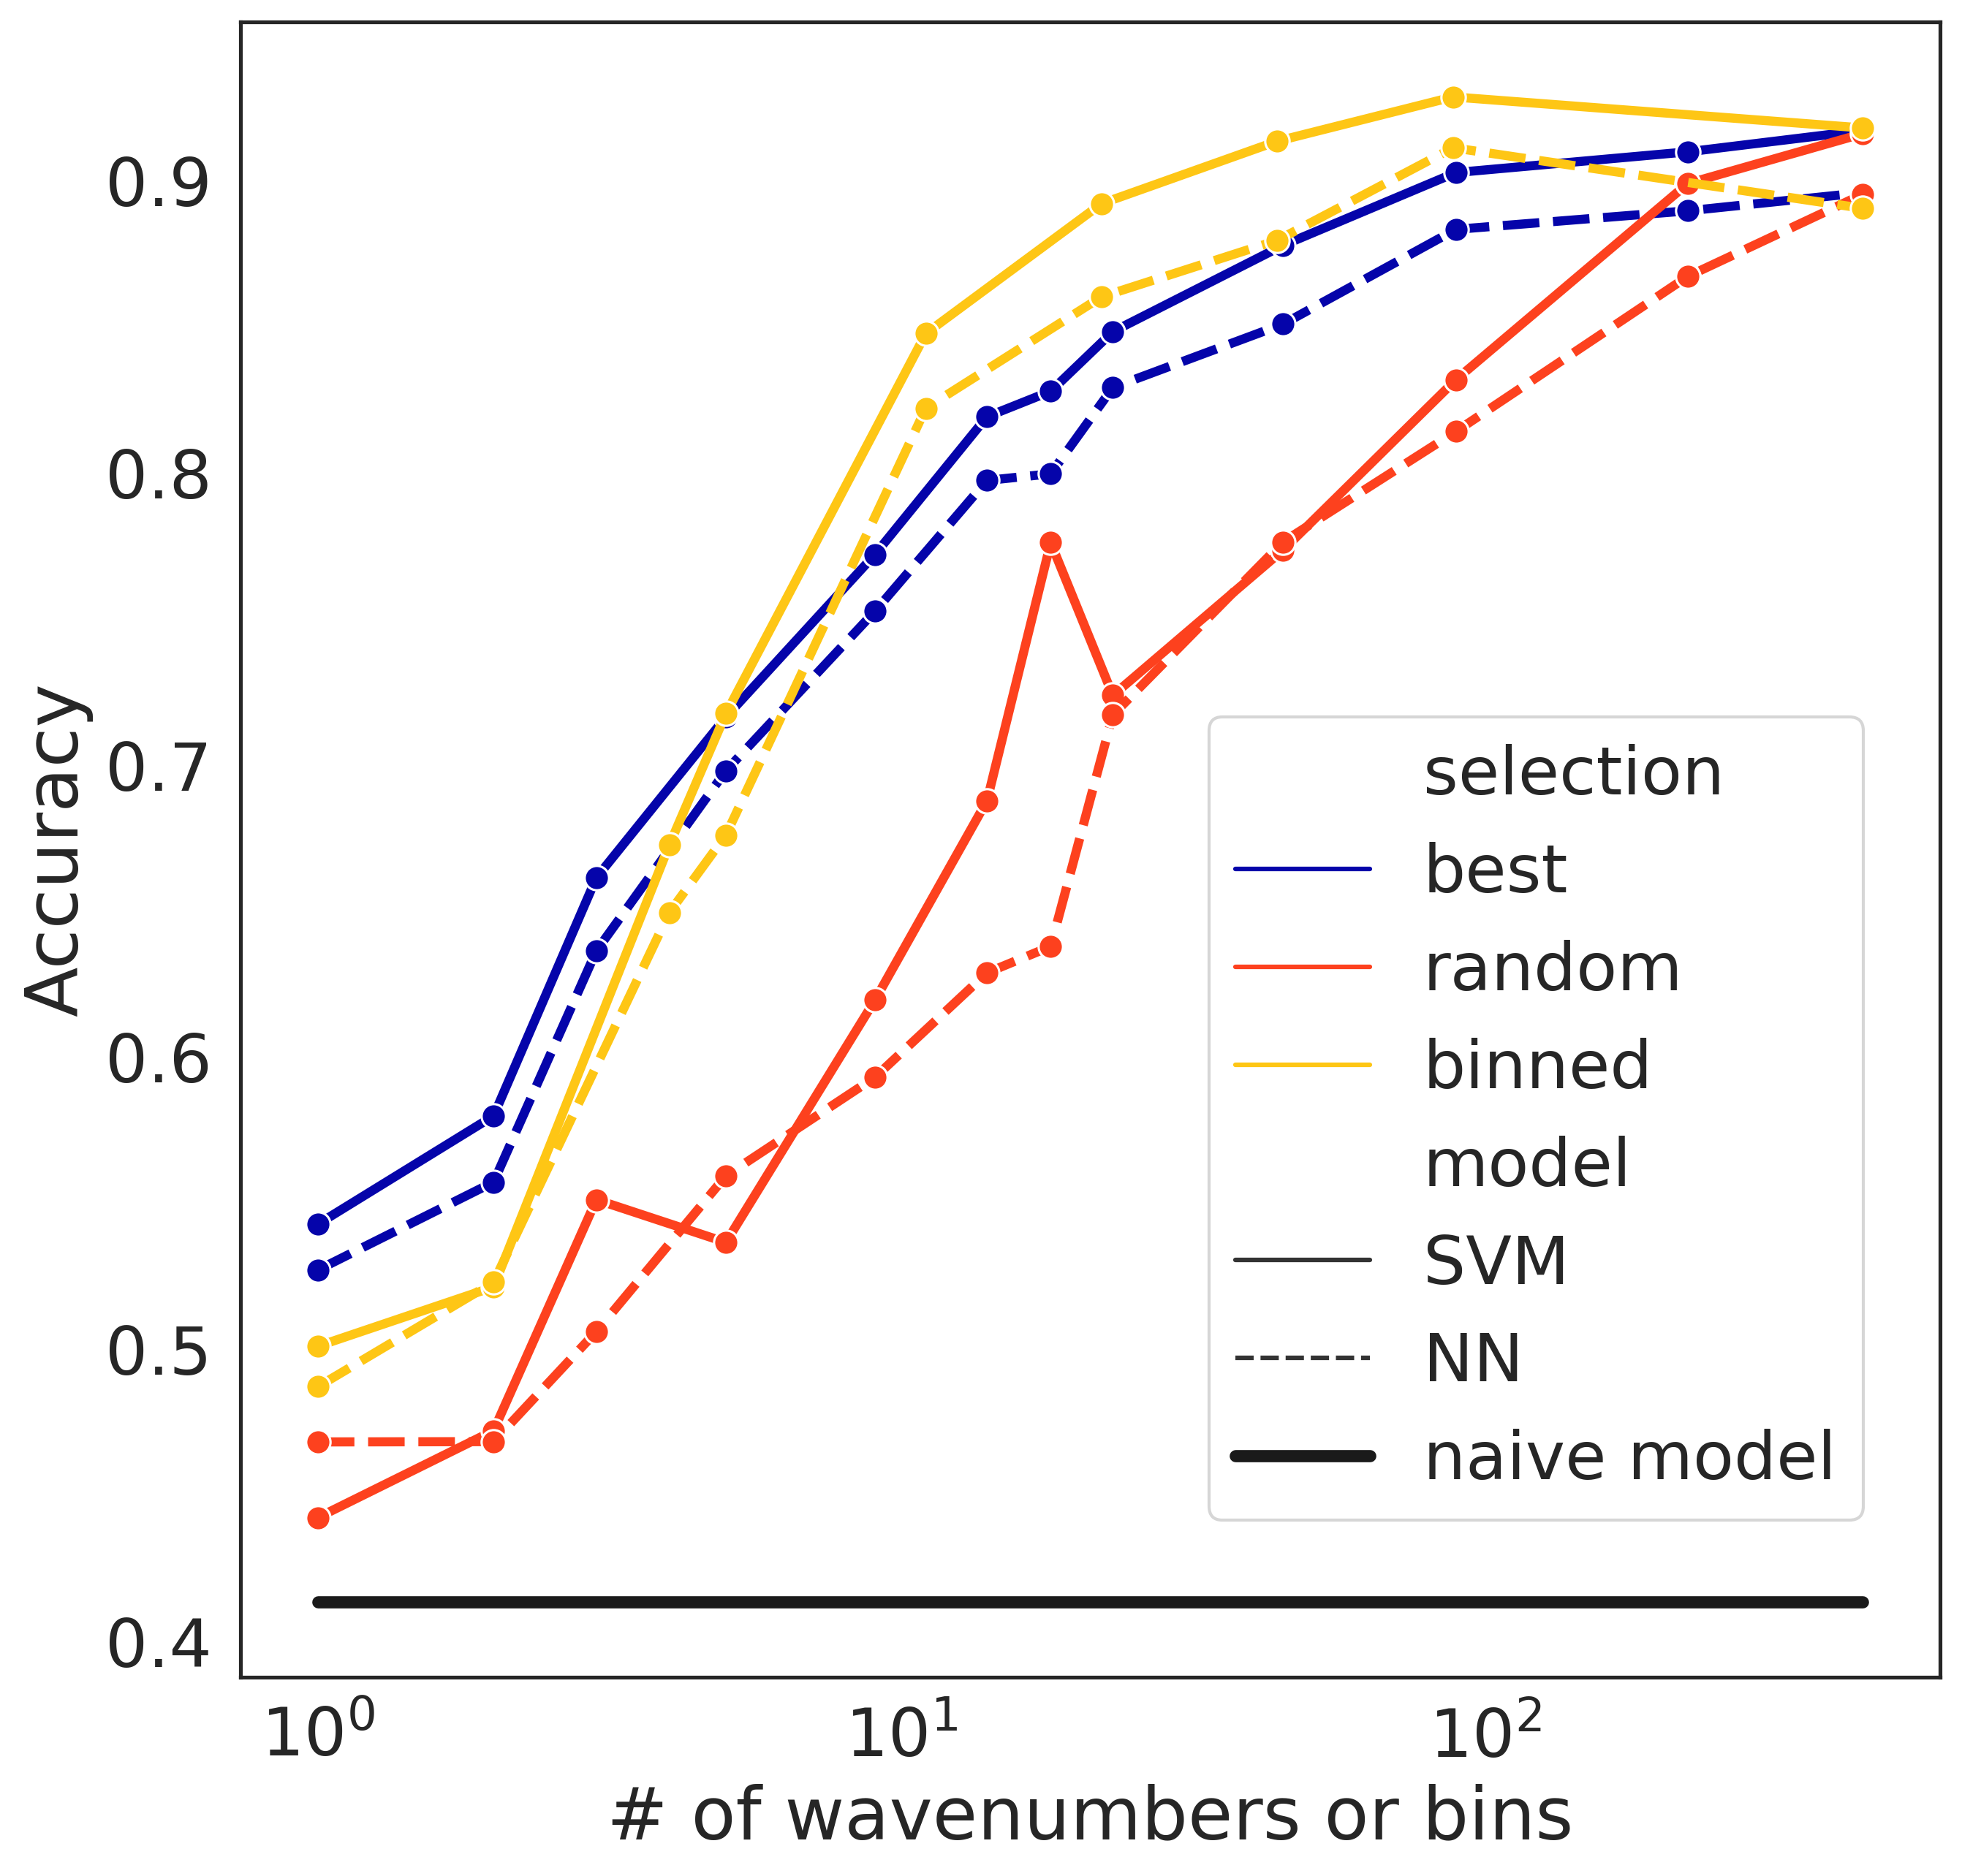

In [22]:
sns.set(style='white',font_scale=2)
fig,ax = plt.subplots(figsize=[10,10])


s = sns.lineplot(data=all_acc_df.sort_values(by='N_measurements'),
                 x='N_measurements',y='Accuracy',hue='selection',
             style= 'model',marker='o',markersize=8,lw=3,
                 palette=mypalette[:3],ax=ax)


s.set(xscale='log')

ax.plot([1,Nfreq],[base_acc,base_acc],'k-',lw=4,label='naive model');
ax.legend()


sns.move_legend(ax, loc= "upper left",  bbox_to_anchor=(0.55, 0.6))


ax.set_xlabel('# of wavenumbers or bins');
fig.savefig('./figures/FigS5.png')

## Optimal filter design with a neural network

In [733]:
spectra = pd.read_csv('raman_fingerprint_raw.csv',index_col=0)
spectra, spectra_cell,spectra_ctype,meta, meta_cell = split_data(spectra)

X = spectra
y = meta['ctype'].map({'iPSC' : 0 , 'NSC' : 1, 'Neuron' :2}).astype('uint8')

# base accuracy: naive model always picking the must abundant class
base_acc = max(meta.groupby(by='ctype').count().iloc[:,0])/meta.shape[0]

# correlation between average spectra
rho_mat = np.corrcoef(spectra_ctype)
rho = (1/3)*(rho_mat[0,1] + rho_mat[0,2] + rho_mat[1,2]) 
print(np.round(rho,2))


0.97


### Training of SVM on raw spectra for comparison

In [88]:
np.random.seed(42)
tf.random.set_seed(42)

Nreps = 5

acc_svm = 0

for i in range(Nreps):
    acc_svm_run,index_svm,is_correct_svm,y_pred,y_test = train_svm(X,y,norm=False)
    acc_svm += acc_svm_run
    
acc_svm /= Nreps

with open('./results/acc_svm_raw.pkl', 'wb') as f:  
    pickle.dump(acc_svm, f)

print(acc_svm)

0.672610096670247


### Training of neural network

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

Nfilters = [1,2,3,4,5,10,15,20,50,100,400]

Nreps = 5

constraints = ['non negative','binary']
norms = ['layer','batch']


acc_filter = { Nfilter : 
                    {norm : 
                         {const : list() 
                         for const in constraints}
                     for norm in norms} 
              for Nfilter in Nfilters}


for Nfilt in Nfilters:
    
    print(Nfilt)
    
    for norm in norms:
        
        for i in range(Nreps):
            acc_nonneg, test_index, is_correct,y_pred,y_test, weights, history_nonneg = train_nn_filter(X,y,
                                                                                            Nfilters=Nfilt, norm = norm, 
                                                                                            epochs=200,batch_size=16)
            
            acc_binary, test_index, is_correct, y_pred,y_test, weights, history_binary = train_nn_filter(X,y,
                                                                                        Nfilters=Nfilt,norm=norm, 
                                                                                        constraint='Binary',preweights=weights,
                                                                                         epochs=200,batch_size=16)

            acc_filter[Nfilt][norm]['non negative'].append(acc_nonneg)
            acc_filter[Nfilt][norm]['binary'].append(acc_binary)
            
            

with open('./results/acc_filter.pkl', 'wb') as f:  
    pickle.dump(acc_filter, f)

### Accuracy for 4, 5 or 10 filters

In [98]:
[acc_filter[i]['layer']['binary'] for i in [4,5]]

[[0.845327615737915,
  0.8555316925048828,
  0.8383458852767944,
  0.8651987314224243,
  0.8523093461990356],
 [0.8931256532669067,
  0.894199788570404,
  0.8931256532669067,
  0.9081632494926453,
  0.8786251544952393]]

In [134]:
np.max(acc_filter[10]['layer']['binary'])

0.9274973273277283

### Simulations

#### Characterize simulated spectra

In [12]:
# create spectra with varying amount of overlap
# and calculate correlation

np.random.seed(42)
tf.random.set_seed(42)

mfracs = np.linspace(0,1,11)

allrs = list()

for mixfrac in mfracs:
        
    rho = list()
    for j in range(10000):
        simspec = simspectra(mixfrac=mixfrac)
        rho.append(np.corrcoef(simspec)[0,1])


    allrs.append(np.mean(rho))
    

#### Test BB-based optimization on simulated data

In [8]:
np.random.seed(42)
tf.random.set_seed(42)


mixfracs = 1 - 10.0**(-np.array([1,2,3,4,5]))
Nphots = [10,20,50,100]


args = [(i,j) for i in mixfracs for j in Nphots]

pool = mp.Pool(mp.cpu_count()-1)
res = pool.starmap(runsimulations,args)

pool.close()
    
allNphot = list() 
finalBB = list() 
allrho = list() 
errs = list()
efficiency = list()

for i in range(len(res)):
    allNphot += res[i][0]
    allrho += res[i][1]
    finalBB += res[i][2]
    errs += res[i][3]
    efficiency += res[i][4] 
    
# set lowest error prob to 1e-6, because 1e6 tests are run
finalBB = np.where(np.array(finalBB) > 0 , np.array(finalBB), 1e-6)
errs = np.where(np.array(errs) > 0 , np.array(errs), 1e-6)


BB_sim_df = pd.DataFrame({'log10(1-correlation)' : np.log10(1-np.array(allrho)),
                                    'N_phot' : allNphot, 
                                        'accuracy' : 1-np.array(errs) })

with open('./results/BB_sim_df.pkl', 'wb') as f:  
    pickle.dump(BB_sim_df, f)


In [9]:
np.mean(efficiency)

0.007925759417661842

#### Test NN model on simulated data

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

Nspectra = 3
Nbins = 50
Nsample = 10000

mixfracs = 1 - 10.0**(-np.array([1,2,3,4,5]))
Nphots = [1000,10000]


Nfilt = 3
Nreps = 5


acc_sim = {mixfrac : {Nphot : list() for Nphot in Nphots} 
              for mixfrac in mixfracs}

rho_sim = {mixfrac : {Nphot : list() for Nphot in Nphots} 
              for mixfrac in mixfracs}

for mixfrac in mixfracs:
    for Nphot in Nphots:
        for i in range(Nreps):

            X,rho = simspectra_wnoise(Nspectra = Nspectra,Nbins = Nbins, mixfrac = mixfrac,Nphot=Nphot,Nsample=Nsample)
            rho_sim[mixfrac][Nphot].append(rho)
            
            y = pd.Series(np.repeat([0,1,2],Nsample))

            acc_nonneg, test_index, is_correct,y_pred,y_test, weights_nonneg, history_nonneg = train_nn_filter(X,y,
                                                                                            Nfilters=Nfilt, norm = 'batch', 
                                                                                            epochs=20,batch_size=128)


            acc_binary, test_index, is_correct, y_pred,y_test, weights, history_binary = train_nn_filter(X,y,
                                                                                        Nfilters=Nfilt,norm='batch', 
                                                                                        constraint='Binary',preweights=weights_nonneg,
                                                                                        epochs=20,batch_size=128)
                    
            acc_sim[mixfrac][Nphot].append(acc_binary)


with open('./results/acc_sim.pkl', 'wb') as f:  
    pickle.dump(acc_sim, f)
    
with open('./results/rho_sim.pkl', 'wb') as f:  
    pickle.dump(rho_sim, f)

# combine
rho_sim_df = pd.DataFrame.from_dict({(mixfrac,Nphot) : rho_sim[mixfrac][Nphot]
                                    for mixfrac in mixfracs
                                    for Nphot in Nphots},orient='index').melt(ignore_index=False)

rho_sim_df.index = pd.MultiIndex.from_tuples(rho_sim_df.index,names=['mixfrac','Nphot'])                        
rho_sim_df = rho_sim_df.reset_index().drop('variable',axis=1)
rho_sim_df.columns = ['mixfrac','Nphot','rho']

acc_sim_df = pd.DataFrame.from_dict({(mixfrac,Nphot) : acc_sim[mixfrac][Nphot]
                                    for mixfrac in mixfracs
                                    for Nphot in Nphots},orient='index').melt(ignore_index=False)

acc_sim_df.index = pd.MultiIndex.from_tuples(acc_sim_df.index,names=['mixfrac','Nphot'])                        
acc_sim_df = acc_sim_df.reset_index().drop('variable',axis=1)
acc_sim_df.columns = ['mixfrac','N_phot','accuracy']
acc_sim_df['log10(1-correlation)'] = np.log10(1-rho_sim_df['rho'])

with open('./results/acc_sim_df.pkl', 'wb') as f:  
    pickle.dump(acc_sim_df, f)
    

In [14]:
# combine BB results with NN results

file = open('./results/acc_sim_df.pkl','rb')
acc_sim_df = pickle.load(file)
file.close()

file = open('./results/BB_sim_df.pkl','rb')
BB_sim_df = pickle.load(file)
file.close()

acc_sim_df = acc_sim_df.groupby(['mixfrac','N_phot']).mean().reset_index().drop('mixfrac',axis=1)
acc_sim_df = acc_sim_df[['log10(1-correlation)','N_phot','accuracy']]
acc_sim_df['model'] = 'NN'

BB_sim_df = BB_sim_df.groupby(np.repeat(np.arange(20),5)).mean()
BB_sim_df['model'] = 'BB'

all_sim_df = pd.concat([acc_sim_df,BB_sim_df])
all_sim_df['N_phot'] = all_sim_df['N_phot'].astype(int)


##### Fig S6

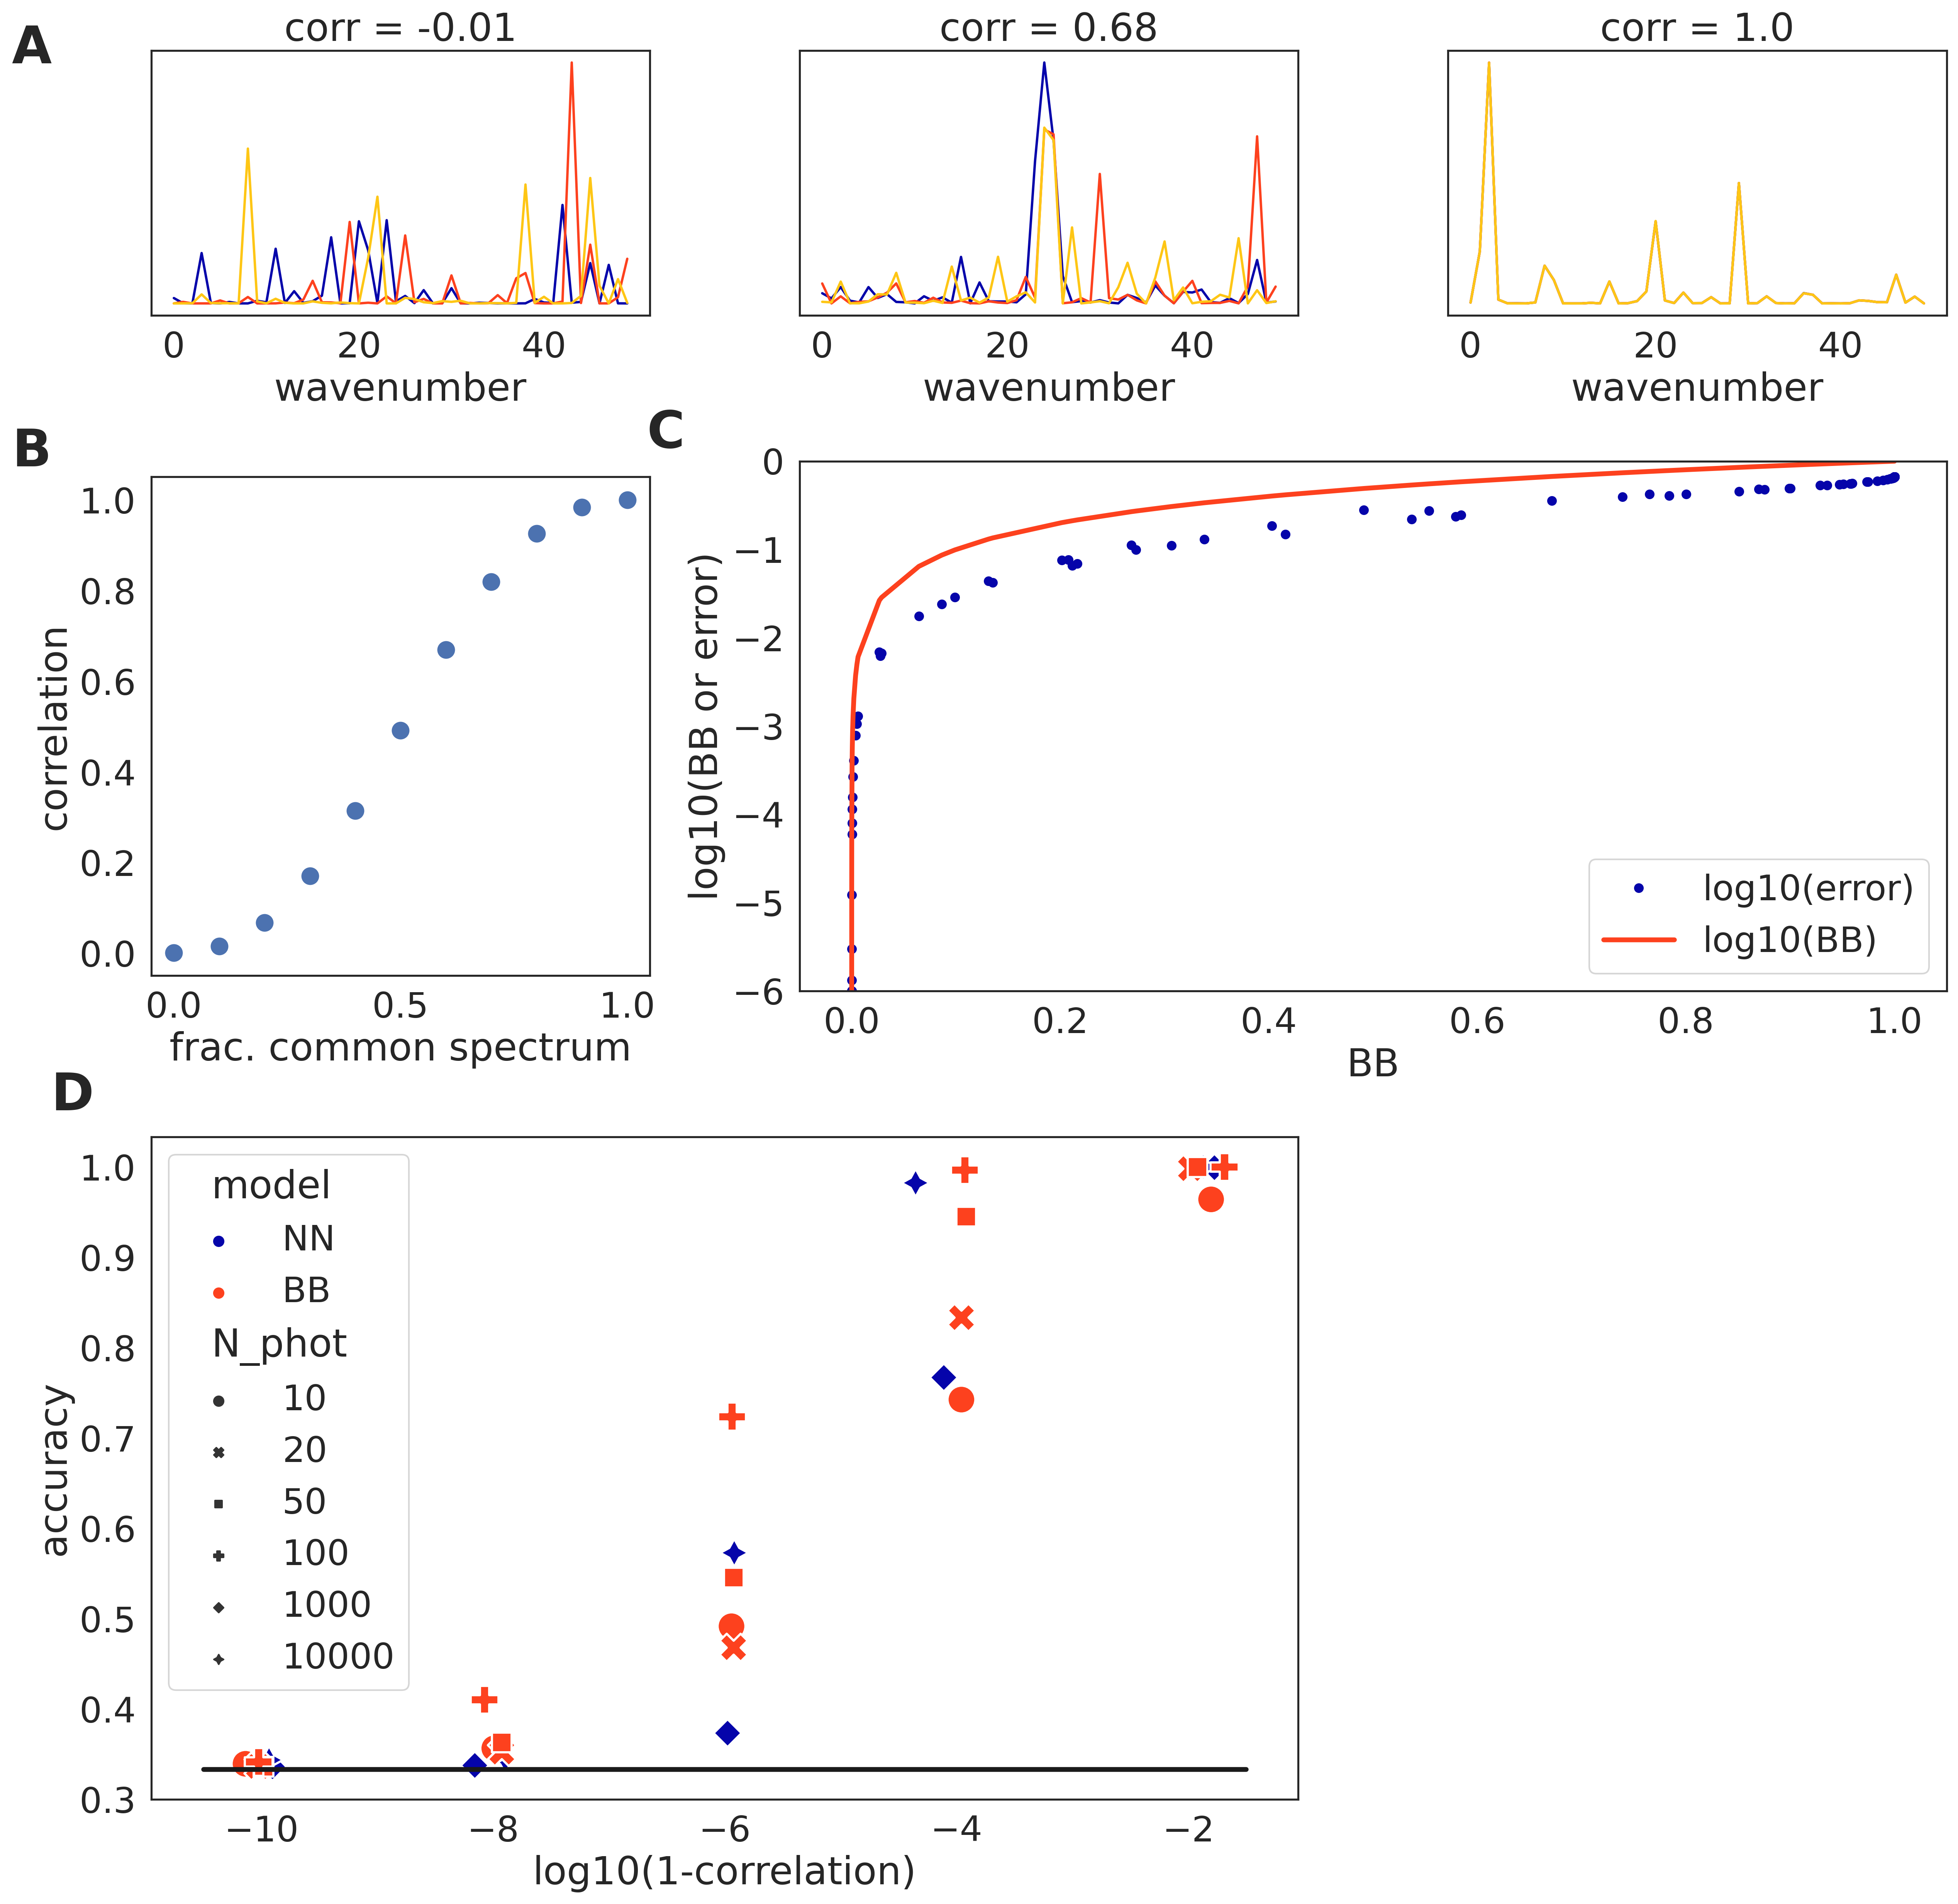

In [15]:
np.random.seed(432)
tf.random.set_seed(432)

sns.set(font_scale=2,style='white')

layout = [['A1', 'A2', 'A3'],
     ['B', 'C','C'],
         ['D','D','E']]

fig,ax = plt.subplot_mosaic(layout,figsize=[20,20],
                            gridspec_kw={'height_ratios': [1,2,2.5]} )

panel_label(ax['A1'],'A',xpos=-0.2,ypos=1.1)

mixfs = [0,0.5,0.999]

count = 0
for mixf in mixfs:
    
    s = simspectra(mixfrac=mixf)
    
    for i in range(3):
            ax['A'+str(count+1)].plot(s[i,:],color=mypalette[i])
            ax['A'+str(count+1)].yaxis.set_ticklabels([])    
            
    rho = (1/3)*(np.corrcoef(s)[0,1] + np.corrcoef(s)[0,2] + np.corrcoef(s)[1,2]) 
    ax['A'+str(count+1)].set_title('corr = ' + str(np.round(rho,2)))
    ax['A'+str(count+1)].set_xlabel('wavenumber')    
    
    count += 1
    
ind = np.argsort(finalBB)
errs_sorted = np.array(errs)[ind]
finalBB_sorted = np.array(finalBB)[ind]

    
panel_label(ax['B'],'B',xpos=-0.2,ypos=1.1)
ax['B'].plot(mfracs,allrs,'o',markersize=10)
ax['B'].set_xlabel('frac. common spectrum')
ax['B'].set_ylabel('correlation')
# ax['B'].set_xlim([0, 1])
# ax['B'].set_ylim([0, 1])
ax['B'].axis('square')

panel_label(ax['C'],'C',xpos=-0.1,ypos=1.1)
ax['C'].plot(finalBB_sorted,np.log10(errs_sorted),'o',
             color=mypalette[0],label='log10(error)',markersize=5)
ax['C'].plot(finalBB_sorted,np.log10(finalBB_sorted),'-',linewidth=3,
             color=mypalette[1],label='log10(BB)')
ax['C'].legend()
ax['C'].set_ylim([-6,0])
ax['C'].set_xlabel('BB')
ax['C'].set_ylabel('log10(BB or error)')



panel_label(ax['D'],'D',xpos=-0.05,ypos=1.1)
# ax[2,2].plot(np.log10(1-np.array(allrho)),1-errs,'o')
sns.scatterplot(data=all_sim_df,x='log10(1-correlation)',y='accuracy',
                hue='model',style='N_phot', s=300,ax=ax['D'],palette=mypalette[:2] )                           
ax['D'].plot([-10.5,-1.5], [1/3,1/3],'-k',linewidth=3 )
ax['D'].set_xlabel('log10(1-correlation)')
ax['D'].set_ylabel('accuracy')

ax['E'].axis('off')

plt.subplots_adjust(hspace=0.3)
plt.subplots_adjust(wspace=0.3)

fig.savefig('./figures/FigS6.png',bbox_inches="tight")


### Test BB-based optimization on real data

In [23]:
spectra = pd.read_csv('raman_fingerprint_raw.csv',index_col=0)
spectra, spectra_cell,spectra_ctype,meta, meta_cell = split_data(spectra)
y = meta['ctype'].map({'iPSC' : 0 , 'NSC' : 1, 'Neuron' :2}).astype('uint8')

s = spectra_ctype.loc[['iPSC','NSC','Neuron'],:].to_numpy()

rho = np.corrcoef(s)
rho_mean = (1/3)*(rho[0,1] + rho[0,2] + rho[1,2]) 

rho_mean

0.970903354481077

In [12]:
Nphot = 1000
Nreps = 20
Nfilts = [1,2,3,4,5,10]
M = 10000

def runBB_ondata(Nfilt,s,y,Nphot,M,Nreps):

    acc = list()

    for i in range(Nreps):
        allBB,f  = optfilt_fixpos(s,Nphot,Nfilt=Nfilt,M=M) 
        acc.append(getacc(f,s,spectra.to_numpy(),y))                

    return Nfilt, np.max(acc)

args = [tuple([Nfilt] + [s,y,Nphot,M,Nreps]) for Nfilt in Nfilts]

pool = mp.Pool(mp.cpu_count()-1)
res_multi = pool.starmap(runBB_ondata,args)
pool.close()

res_multi

[(1, 0.413622690159003),
 (2, 0.39406961753330466),
 (3, 0.39213579716373015),
 (4, 0.39363987967339925),
 (5, 0.3917060593038247),
 (10, 0.3937473141383756)]

In [ ]:
Nfilts = [1,2,3,4,5,10,15,20]
Nreps = range(5)
M = 10000


def runBB_normal_ondata(Nfilt,Nrep):
    
    np.random.seed(Nfilt*10+Nrep)
    tf.random.set_seed(Nfilt*10+Nrep)

    allBB,f  = optfilt_normal_fixpos(spectra,y,Nfilt=Nfilt,M=M) 
    means,cov = getBB_normal(f,spectra,y,getstats=True)
    acc = getacc_normal(f,spectra,means,cov,y)               

    return Nfilt, Nrep, acc, allBB


args = [(Nfilt,Nrep) for Nfilt in Nfilts for Nrep in Nreps]


pool = mp.Pool(mp.cpu_count()-1)
res_normal = pool.starmap(runBB_normal_ondata,args)
pool.close()

allNfiltBB = list()
allaccBB = list()

for i in range(len(res_normal)):
    allNfiltBB.append(res_normal[i][0])
    allaccBB.append(res_normal[i][2])


acc_BB_ondata_df = pd.DataFrame({'Nfilt' : allNfiltBB, 'accuracy' : allaccBB })

with open('./results/acc_BB_ondata_df.pkl', 'wb') as f:  
    pickle.dump(acc_BB_ondata_df, f)

### Comparison of methods

In [25]:
# base accuracy: naive model always picking the must abundant class
base_acc = max(meta.groupby(by='ctype').count().iloc[:,0])/meta.shape[0]

file = open('./results/acc_svm_raw.pkl','rb')
acc_svm = pickle.load(file)
file.close()

file = open('./results/acc_BB_ondata_df.pkl','rb')
acc_BB_ondata_df = pickle.load(file)
file.close()

file = open('./results/acc_filter.pkl','rb')
acc_filter = pickle.load(file)
file.close()

Nfilters = [1,2,3,4,5,10,15,20,50,100,400]
constraints = ['non negative','binary']
norms = ['layer','batch']

acc_filter_df = pd.DataFrame.from_dict({(norm,const,Nfilter) : acc_filter[Nfilter][norm][const]
                                    for norm in norms
                                    for const in constraints
                                    for Nfilter in Nfilters},orient='index').melt(ignore_index=False)
                        
acc_filter_df.index = pd.MultiIndex.from_tuples(acc_filter_df.index,names=['normalization','constraint','# filters'])                        
acc_filter_df = acc_filter_df.reset_index().drop('variable',axis=1)
acc_filter_df['condition'] = acc_filter_df['normalization'] + ' , ' + acc_filter_df['constraint'] 

#### Figure 3

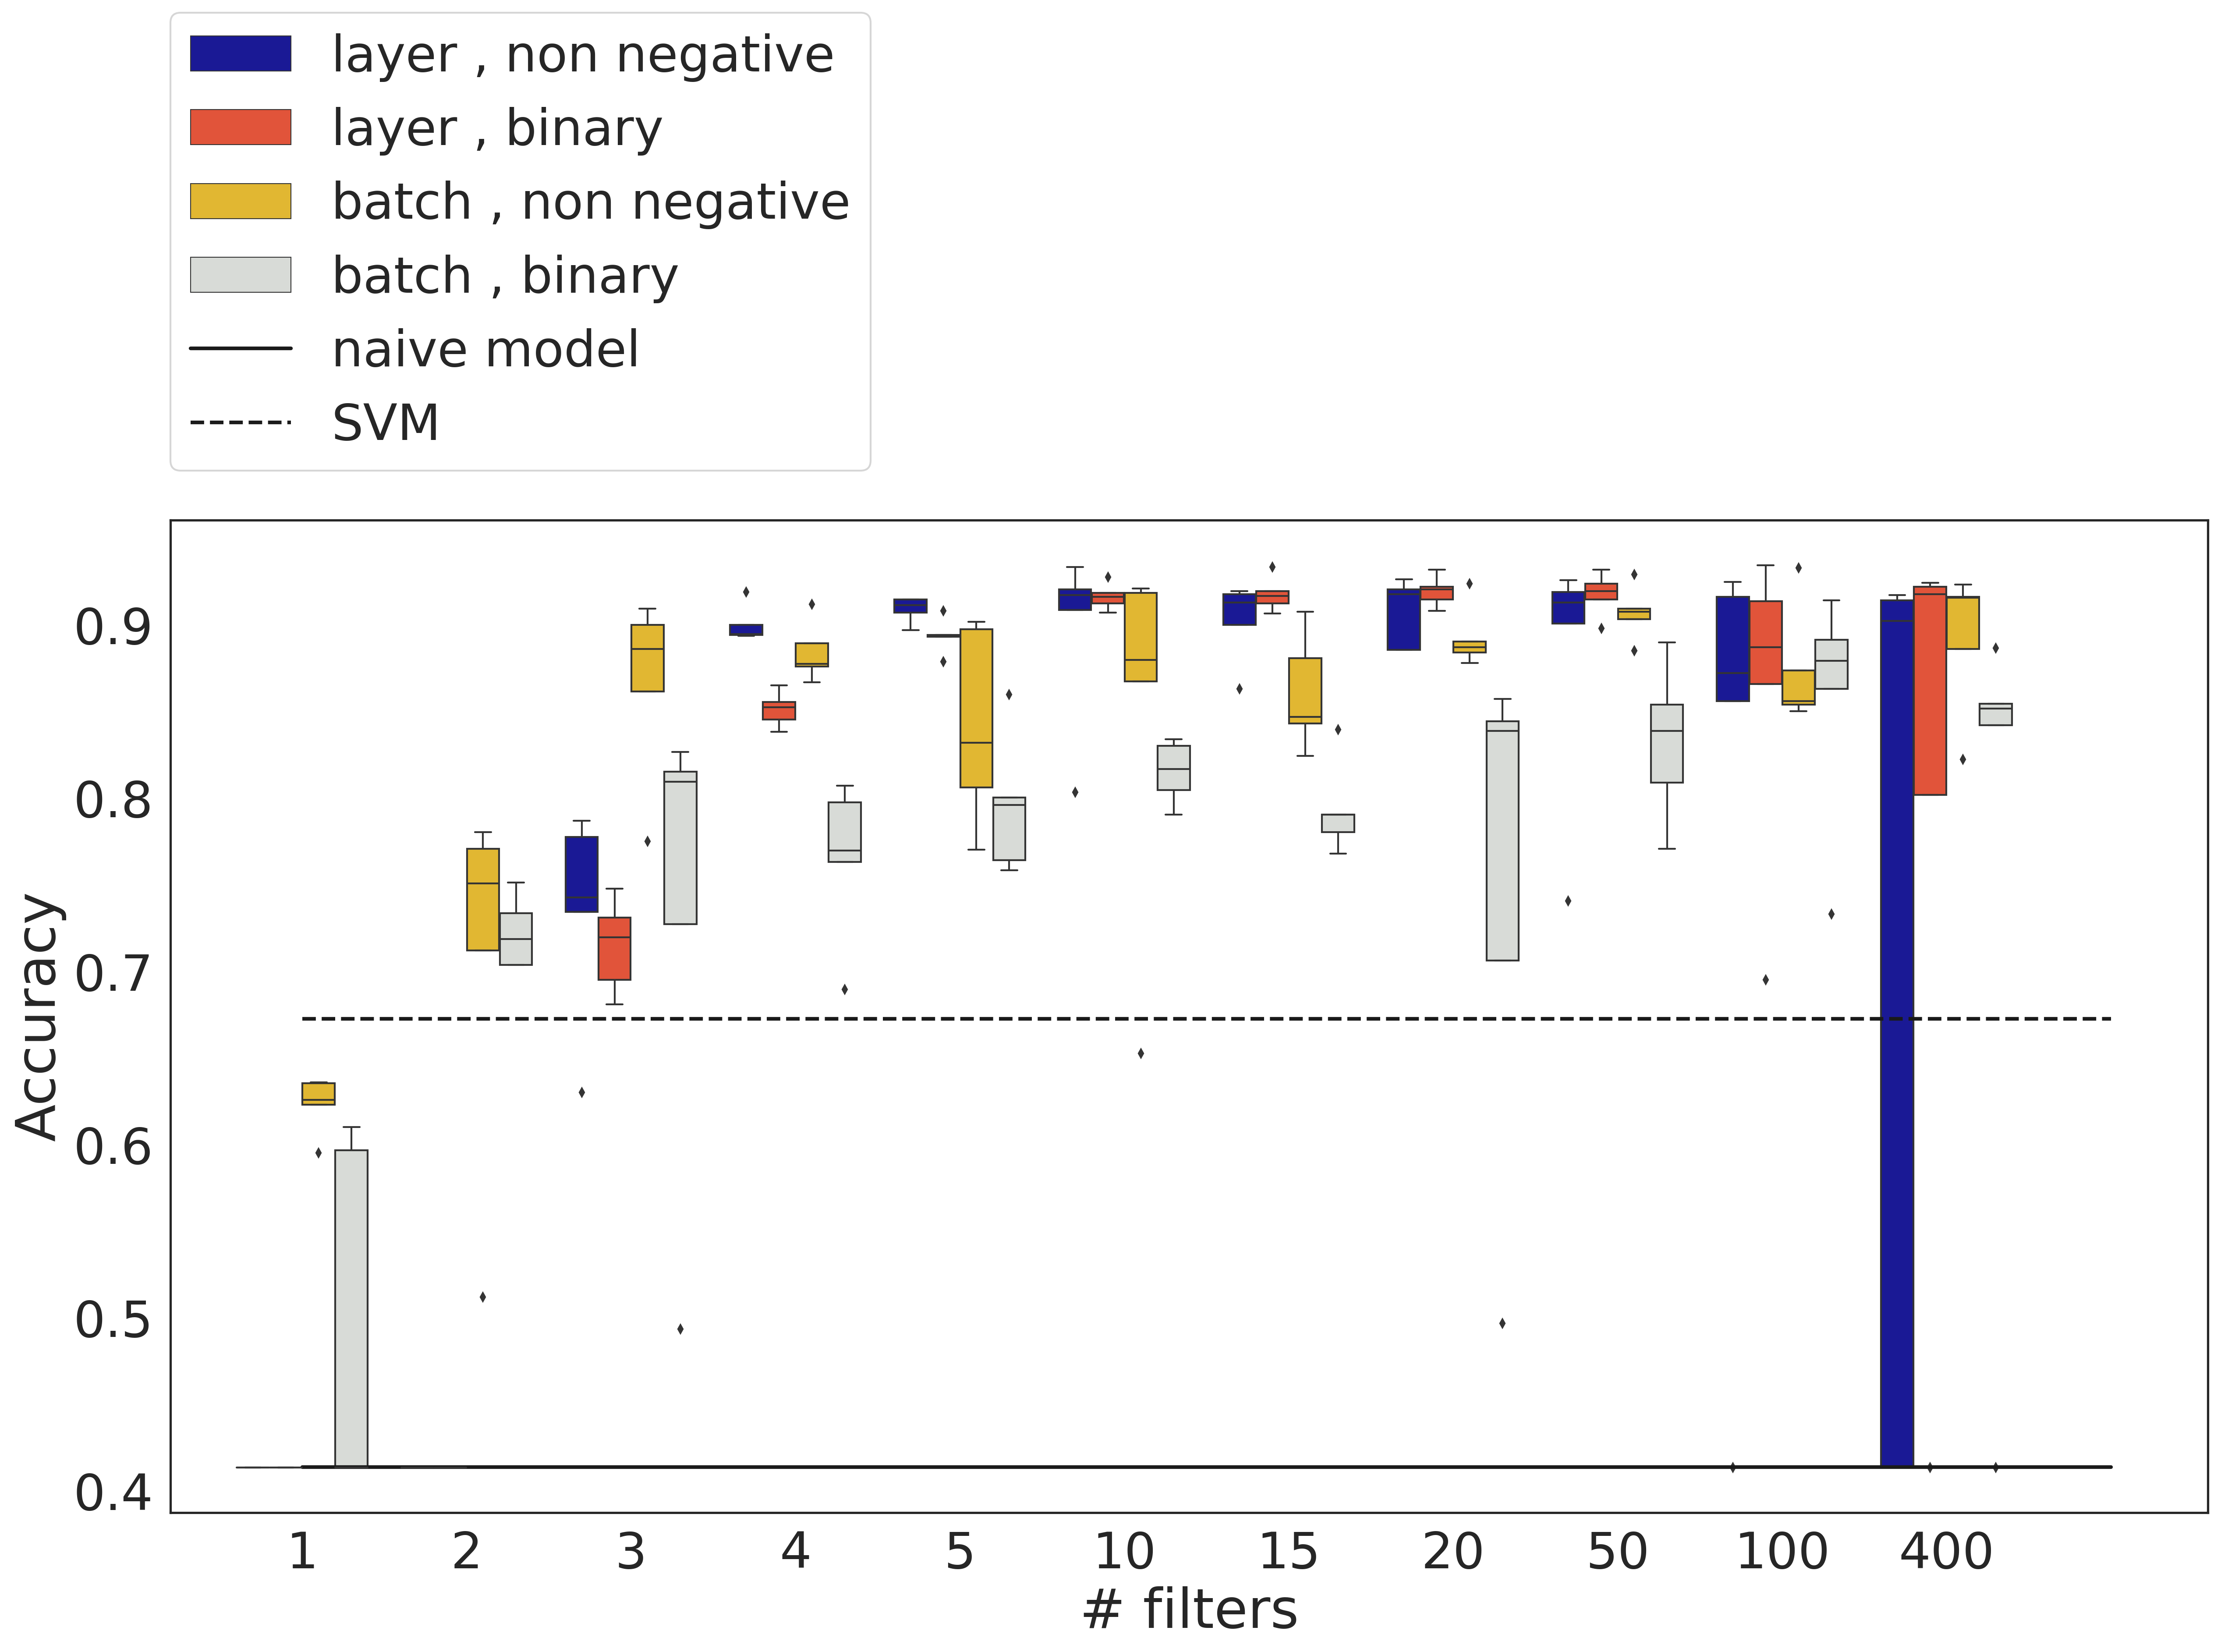

In [90]:
fig,ax = plt.subplots(figsize=[20,10])
s = sns.boxplot(data=acc_filter_df,x='# filters',y='value',hue='condition',ax=ax,
                palette=mypalette,linewidth=1,fliersize=3)
ax.plot([0,11],[base_acc,base_acc],'k-',lw=2,label = 'naive model');
ax.plot([0,11],[acc_svm,acc_svm],'k--',lw=2,label = 'SVM');
# s.set(xscale='log')
ax.set_ylabel('Accuracy')
ax.legend(bbox_to_anchor=(0, 1.05), loc=3, borderaxespad=0.)

fig.savefig('./figures/Fig3_ver1.png')

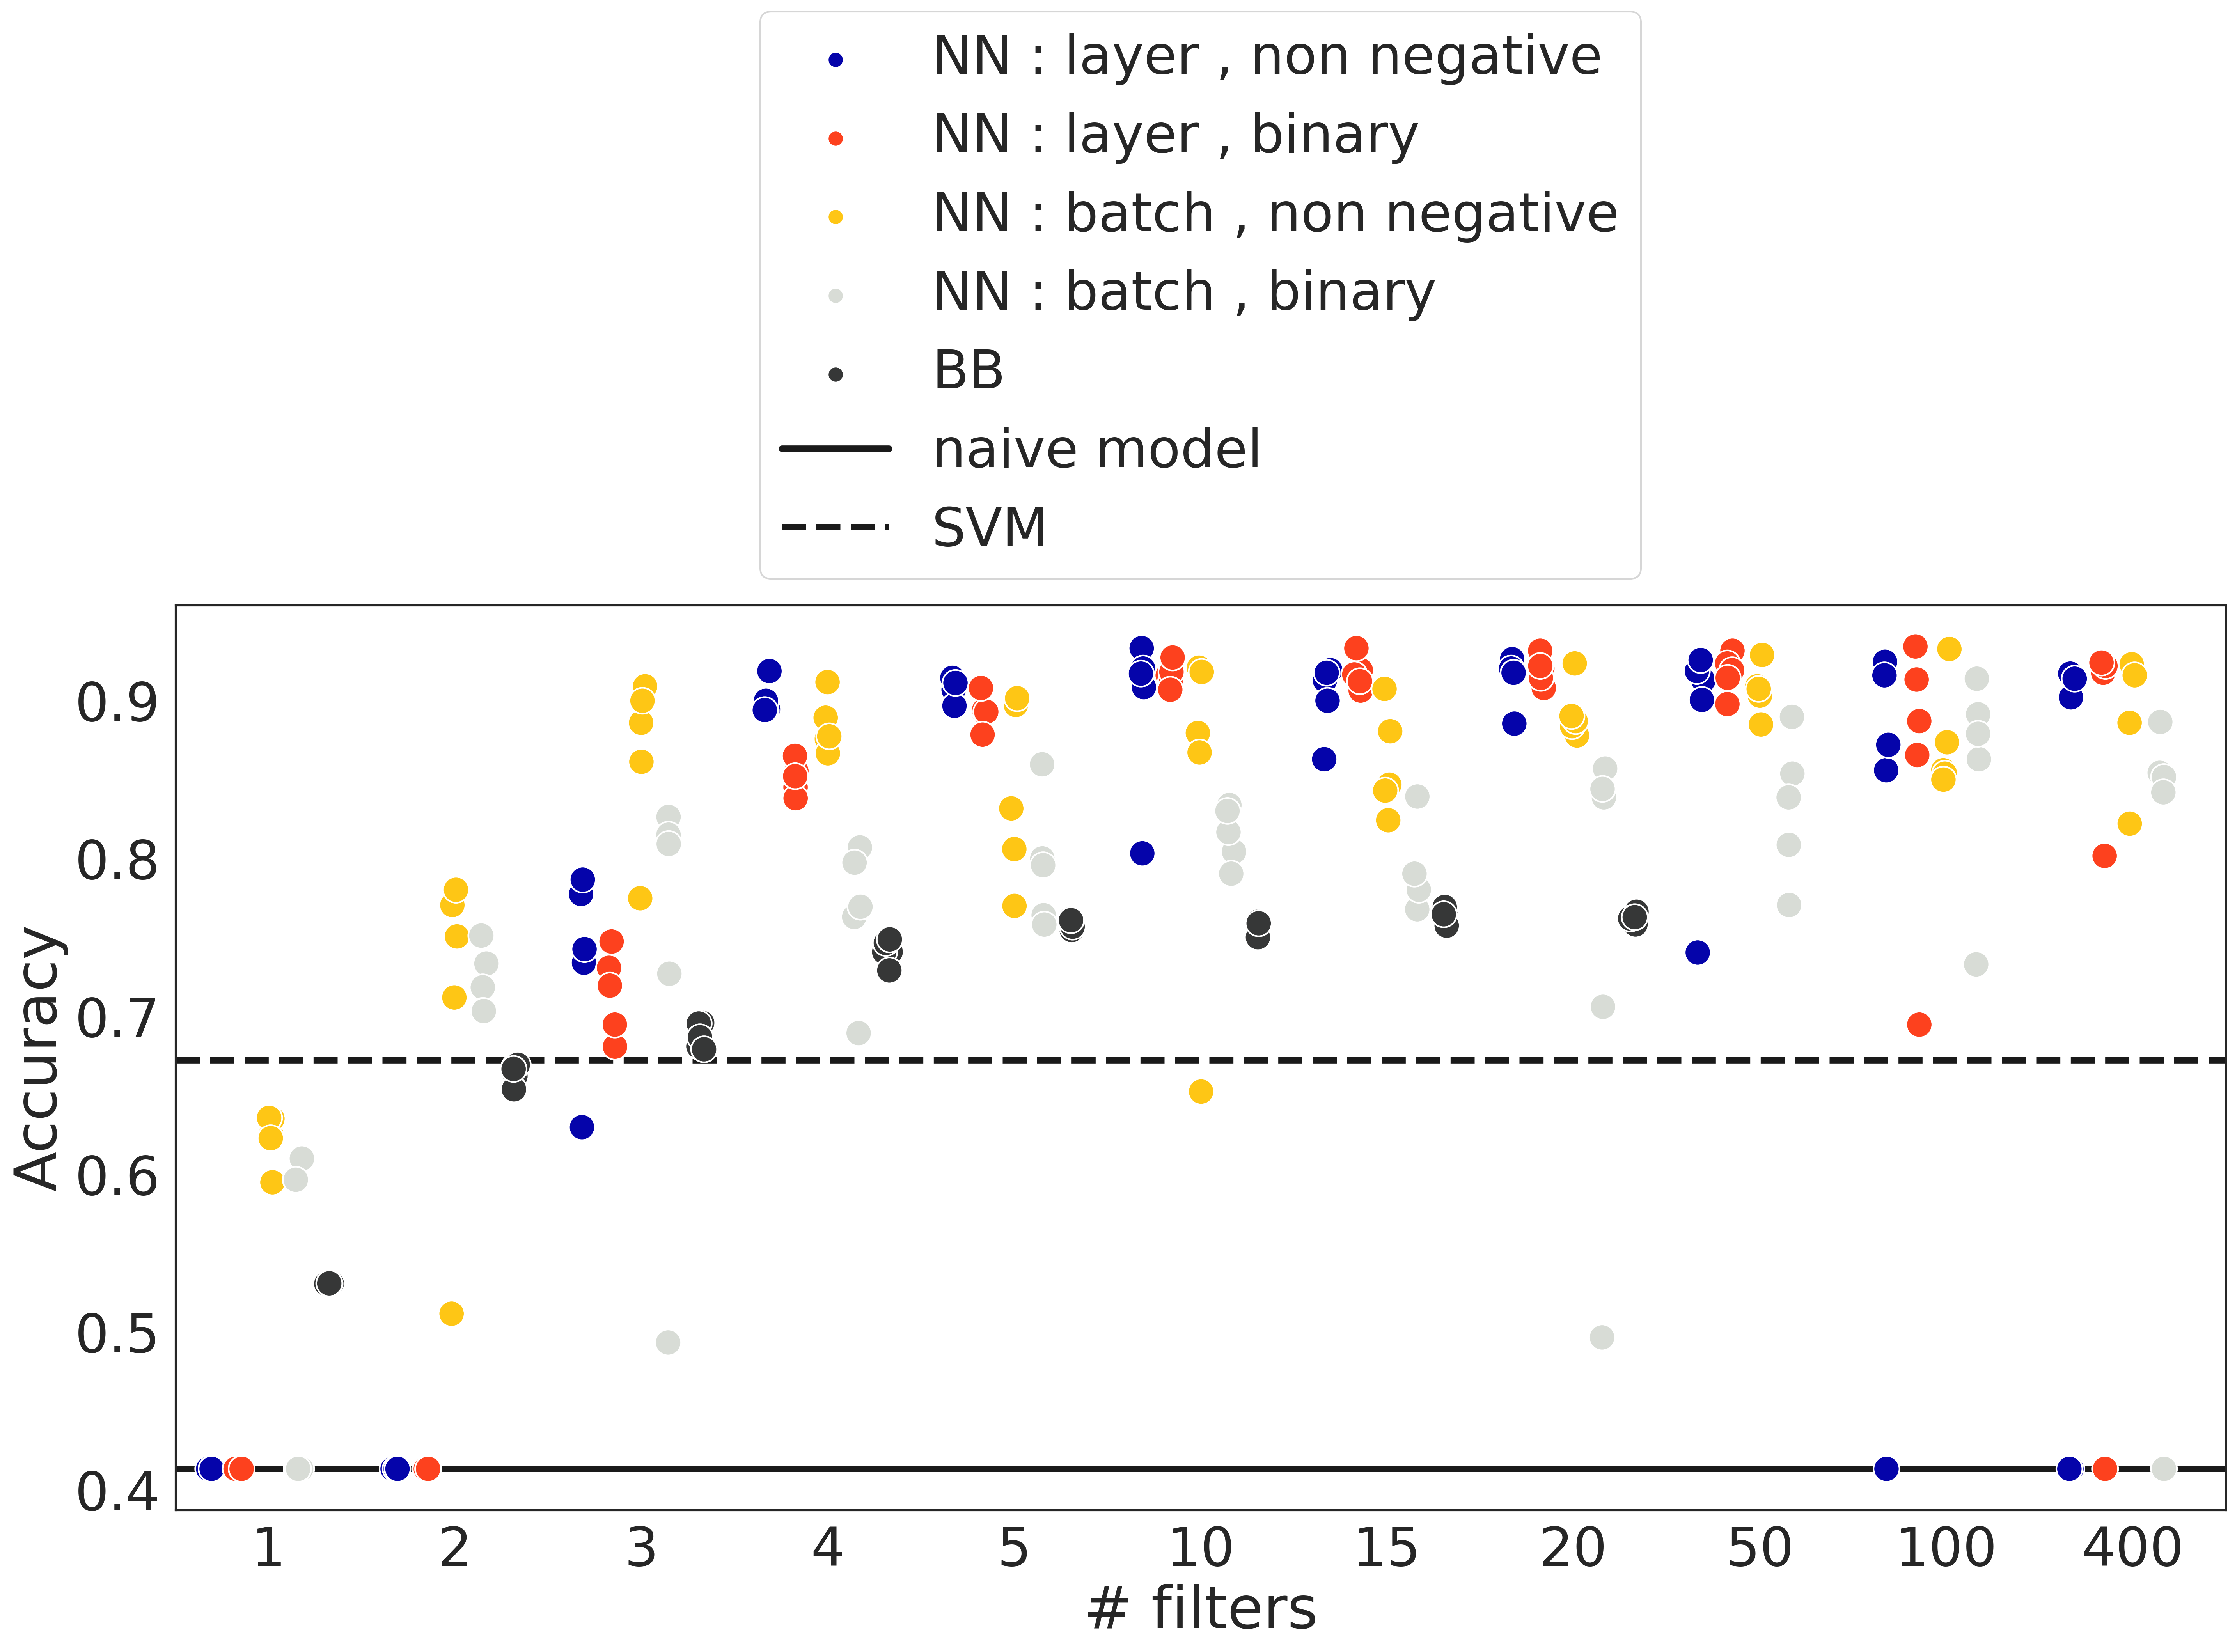

In [26]:
acc_filter_df_plot = acc_filter_df[['# filters','value','condition']].copy()
acc_filter_df_plot['condition'] = ['NN : ' + s for s in acc_filter_df_plot['condition']]

acc_BB_ondata_df_plot = acc_BB_ondata_df.copy()
acc_BB_ondata_df_plot.columns = ['# filters','value']
acc_BB_ondata_df_plot['condition'] = 'BB'

acc_filter_df_plot = pd.concat([acc_filter_df_plot,acc_BB_ondata_df_plot])

sns.set(font_scale=3,style='white')
fig,ax = plt.subplots(figsize=[20,15])


s = sns.stripplot(data=acc_filter_df_plot,x='# filters',y='value',hue='condition',
                       jitter=0.1,dodge=True,
                        palette=mypalette+['xkcd:dark grey'],ax=ax,s=16,edgecolor="white",linewidth=1)



ax.plot([-0.5,10.5],[base_acc,base_acc],'k-',lw=4,label = 'naive model');
ax.plot([-0.5,10.5],[acc_svm,acc_svm],'k--',lw=4,label = 'SVM');
ax.set_xlim([-0.5,10.5])
# s.set(xscale='log')
ax.set_ylabel('Accuracy')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1))
plt.tight_layout()
fig.savefig('./figures/Fig3_ver2.png')


## Classification with 5 filters

In [602]:
spectra = pd.read_csv('raman_fingerprint_raw.csv',index_col=0)
spectra, spectra_cell,spectra_ctype,meta, meta_cell = split_data(spectra)

X = spectra
y = meta['ctype'].map({'iPSC' : 0 , 'NSC' : 1, 'Neuron' :2}).astype('uint8')

### Train 5 filter model again

In [603]:
np.random.seed(42)
tf.random.set_seed(42)

Nfilters = 5

acc_nonneg, test_index, is_correct, y_pred,y_test,weights_nonneg, history_nonneg = train_nn_filter(X,y,Nfilters=Nfilters,
                                                                                         epochs=200,batch_size=16)

acc_binary, test_index, is_correct, y_pred,y_test,weights_binary, history_binary = train_nn_filter(X,y,Nfilters=Nfilters, 
                                                                                constraint='Binary',preweights=weights_nonneg,
                                                                                    epochs=200,batch_size=16)
    


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [604]:
acc_binary

0.8813104033470154

#### Figure 4

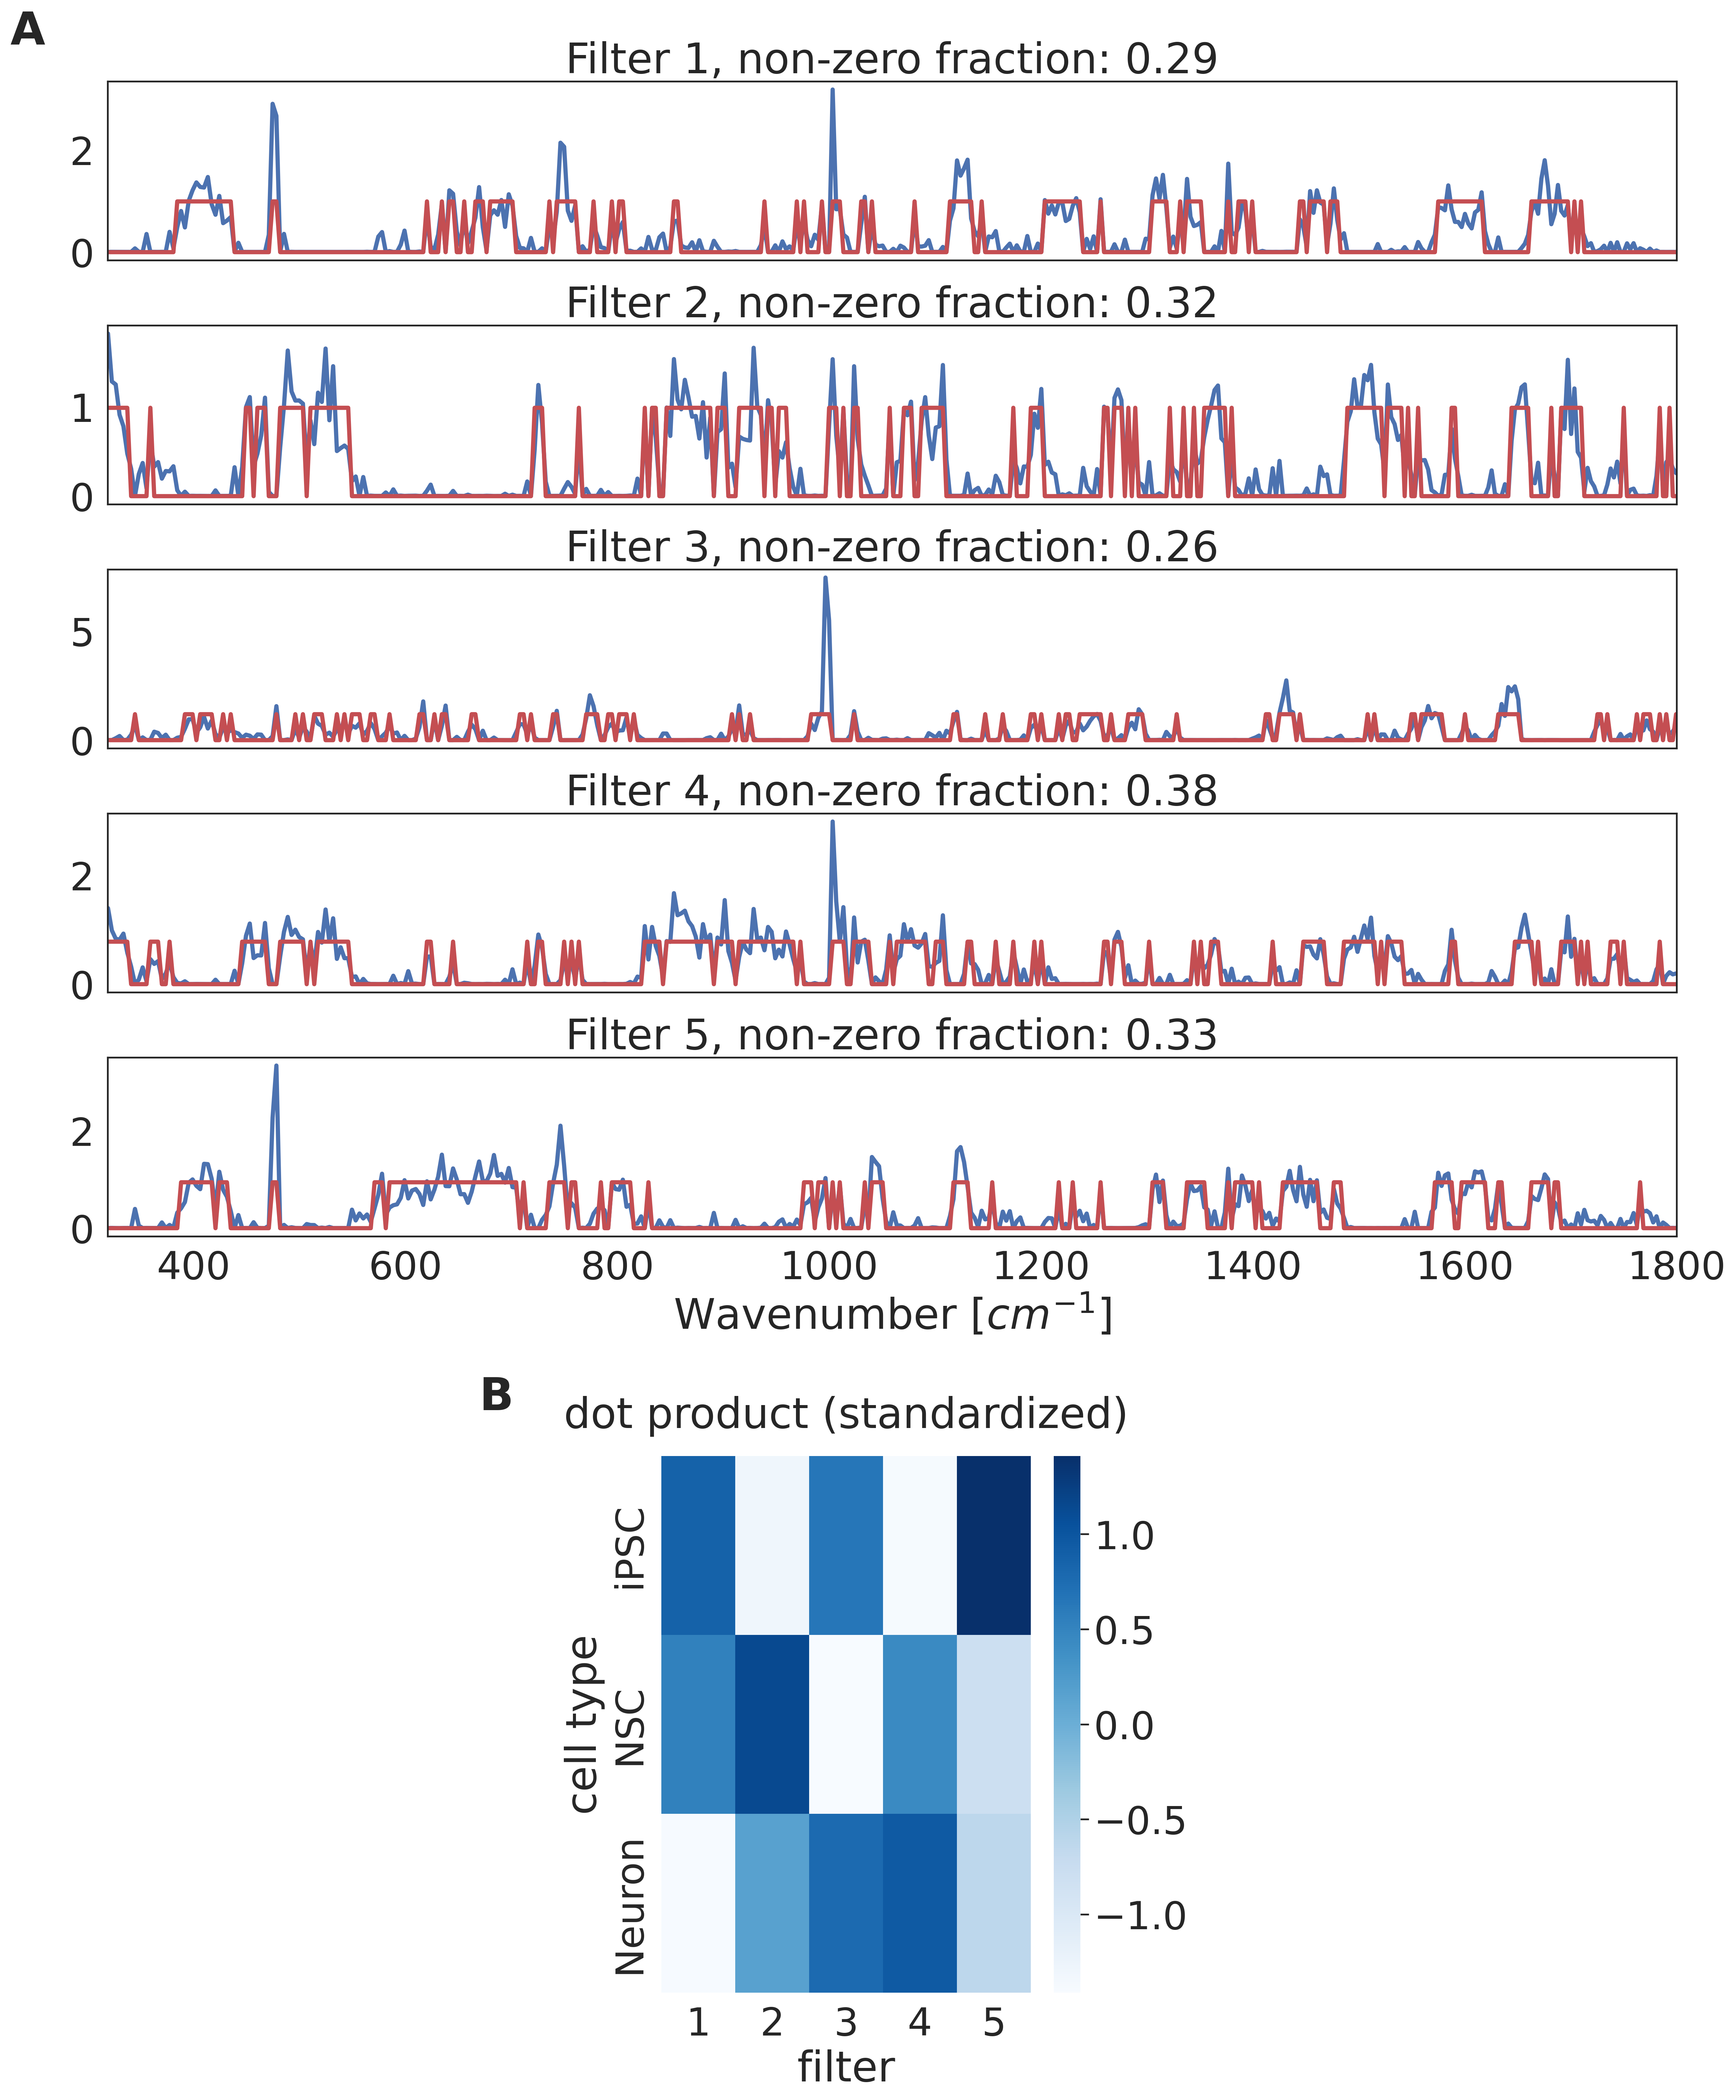

In [607]:
sns.set(font_scale=2.5,style='white')

fig = plt.figure(figsize=[20,5*Nfilters])
gs = GridSpec(Nfilters+2, 3, figure=fig,height_ratios = [1,1,1,1,1,0.5,3])

for i in range(Nfilters):
    ax = fig.add_subplot(gs[i, :])
    
    if i == 0:
        panel_label(ax,'A',xpos=-0.04,ypos=1.4)
        
    ax.plot(spectra.columns,weights_nonneg[0][:,i],lw=3)
    ax.plot(spectra.columns,weights_binary[0][:,i],'r',lw=3)
    ax.set_xlim([319,1800])
    
    nonzero_frac= np.round(
        np.sum(weights_binary[0][:,i] > 0)/len(weights_binary[0][:,i]),2)
    
    if i < Nfilters-1:
        ax.xaxis.set_ticklabels([])
    
    ax.set_title('Filter ' + str(i+1) + ', non-zero fraction: ' + str(nonzero_frac))

ax.set_xlabel('Wavenumber $[ cm^{-1} ]$')

# ax = fig.add_subplot(gs[Nfilters,:])

ax = fig.add_subplot(gs[Nfilters+1, 1])
panel_label(ax,'B',xpos=-0.4,ypos=1.15)

activ_dict =  {str(i+1) :  
               np.dot(spectra,weights_binary[0][:,i]) for i in range(Nfilters)}
  

activ_df = pd.DataFrame(activ_dict)
activ_df['cell type'] =  meta['ctype']
activ_table = (activ_df.groupby('cell type').mean()
               .apply(lambda x : (x-np.mean(x))/np.std(x),axis=1)
                 .apply(lambda x : (x-np.mean(x))/np.std(x),axis=0))
s = sns.heatmap(activ_table,cmap='Blues',ax=ax)
s.set(xlabel='filter')

ax.set_title('dot product (standardized)',pad=20)


# plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

fig.savefig('./figures/Fig4.png')

### Compare training scenarios

In [602]:
spectra = pd.read_csv('raman_fingerprint_raw.csv',index_col=0)
spectra, spectra_cell,spectra_ctype,meta, meta_cell = split_data(spectra)

X = spectra
y = meta['ctype'].map({'iPSC' : 0 , 'NSC' : 1, 'Neuron' :2}).astype('uint8')

#### All data is used

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

Nfilt = 5
Nreps = 5

y_pred_all = list()
y_test_all = list()
acc_binary_all = list()

for i in range(Nreps):
    acc_nonneg, test_index, is_correct, y_pred,y_test,weights_nonneg, history_nonneg = train_nn_filter(X,y,Nfilters=Nfilt,
                                                                                         epochs=200,batch_size=16)

    acc_binary, test_index, is_correct, y_pred,y_test,weights_binary, history_binary = train_nn_filter(X,y,Nfilters=Nfilt, 
                                                                                constraint='Binary',preweights=weights_nonneg,
                                                                                    epochs=200,batch_size=16)
    
    y_pred_all += list(y_pred)
    y_test_all += list(y_test)
    acc_binary_all.append(acc_binary)
    
    
with open('./results/acc_binary_all.pkl', 'wb') as f:  
    pickle.dump(acc_binary_all, f)

with open('./results/y_pred_all.pkl', 'wb') as f:  
    pickle.dump(y_pred_all, f)

with open('./results/y_test_all.pkl', 'wb') as f:  
    pickle.dump(y_test_all, f)


In [43]:
file = open('./results/acc_binary_all.pkl','rb')
acc_binary_all = pickle.load(file)
file.close()

np.max(acc_binary_all)

0.9006444811820984

#### Train on two cell lines, predict the third

In [32]:
spectra = pd.read_csv('raman_fingerprint_raw.csv',index_col=0)
spectra, spectra_cell,spectra_ctype,meta, meta_cell = split_data(spectra)

X = spectra
y = meta['ctype'].map({'iPSC' : 0 , 'NSC' : 1, 'Neuron' :2}).astype('uint8')

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

Nfilters = 5

y_pred_across = list()
y_test_across = list()
acc_binary_across = list()

clines = list(set(meta['cline']))


for cline in clines:
    is_train = (meta['cline'] != cline)


    acc_nonneg, test_index, is_correct, y_pred,y_test,weights_nonneg, history_nonneg = train_nn_filter(X,y,Nfilters=Nfilters,
                                                                                         epochs=200,batch_size=16,is_train=is_train)

    acc_binary, test_index, is_correct, y_pred,y_test,weights_binary, history_binary = train_nn_filter(X,y,Nfilters=Nfilters, 
                                                                                constraint='Binary',preweights=weights_nonneg,
                                                                                    epochs=200,batch_size=16,is_train=is_train)

    y_pred_across += list(y_pred)
    y_test_across += list(y_test)
    acc_binary_across.append(acc_binary)
    
    
with open('./results/acc_binary_across.pkl', 'wb') as f:  
    pickle.dump(acc_binary_across, f)

with open('./results/y_pred_across.pkl', 'wb') as f:  
    pickle.dump(y_pred_across, f)

with open('./results/y_test_across.pkl', 'wb') as f:  
    pickle.dump(y_test_across, f)

In [35]:
np.mean(acc_binary_across)

0.6948109666506449

#### Train and predict within a cell line

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

Nfilters = 5
Nreps = 5

y_pred_within = list()
y_test_within = list()
acc_binary_within = list()

clines = list(set(meta['cline']))


for cline in clines:
    is_cline = (meta['cline'] != cline)

    for i in range(Nreps):
        acc_nonneg, test_index, is_correct, y_pred,y_test,weights_nonneg, history_nonneg = train_nn_filter(X.loc[is_cline,:],y[is_cline],
                                                                                                           Nfilters=Nfilters,
                                                                                                           epochs=200,batch_size=16)
                                                                                                           
                                                                                                                                                                                                     

        acc_binary, test_index, is_correct, y_pred,y_test,weights_binary, history_binary = train_nn_filter(X.loc[is_cline,:],y[is_cline],
                                                                                                           Nfilters=Nfilters, 
                                                                                                           epochs=200,batch_size=16) 
                                                                                                      
                                                                                                          

        y_pred_within += list(y_pred)
        y_test_within += list(y_test)
        acc_binary_within.append(acc_binary)
    
    
with open('./results/acc_binary_within.pkl', 'wb') as f:  
    pickle.dump(acc_binary_within, f)

with open('./results/y_pred_within.pkl', 'wb') as f:  
    pickle.dump(y_pred_within, f)

with open('./results/y_test_within.pkl', 'wb') as f:  
    pickle.dump(y_test_within, f)

In [34]:
[np.max(acc_binary_within),np.mean(acc_binary_within)]

[0.9369009733200073, 0.8675085067749023]

#### Training on binned spectra

In [10]:
spectra = pd.read_csv('raman_fingerprint_raw.csv',index_col=0)
spectra, spectra_cell,spectra_ctype,meta, meta_cell = split_data(spectra)

X = spectra
y = meta['ctype'].map({'iPSC' : 0 , 'NSC' : 1, 'Neuron' :2}).astype('uint8')

In [35]:
np.random.seed(42)
tf.random.set_seed(42)

Nfilt = 5
Nreps = 5 #number of runs per condition

# size of frequency interval
deltas = [1,5,10,20,40]

acc_bin_five = {delta : list() for delta in deltas} 

allNbin_five = list()

for delta in deltas:

    print(delta)

    
    # average over frequency bands for individual spectra        
    spec_mean = pd.DataFrame()

    for i in range(int(spectra.shape[1]/delta)):
        spec_mean = pd.concat((spec_mean,spectra.iloc[:,delta*i:min([spectra.shape[1],delta*(i+1)])].mean(axis=1)),axis=1)
                
    allNbin_five.append(spec_mean.shape[1])    
    
    
    for i in range(Nreps):
        acc_nonneg, test_index, is_correct, y_pred,y_test,weights_nonneg, history_nonneg = train_nn_filter(spec_mean,y,Nfilters=Nfilt,
                                                                                             epochs=200,batch_size=16)

        acc_binary, test_index, is_correct, y_pred,y_test,weights_binary, history_binary = train_nn_filter(spec_mean,y,Nfilters=Nfilt, 
                                                                                    constraint='Binary',preweights=weights_nonneg,
                                                                                        epochs=200,batch_size=16)

        acc_bin_five[delta].append(acc_binary)


with open('./results/acc_bin_five.pkl', 'wb') as f:  
    pickle.dump(acc_bin_five, f)
    
with open('./results/allNbin_five.pkl', 'wb') as f:  
    pickle.dump(allNbin_five, f)

1
5
10
20
40


#### Figure S7

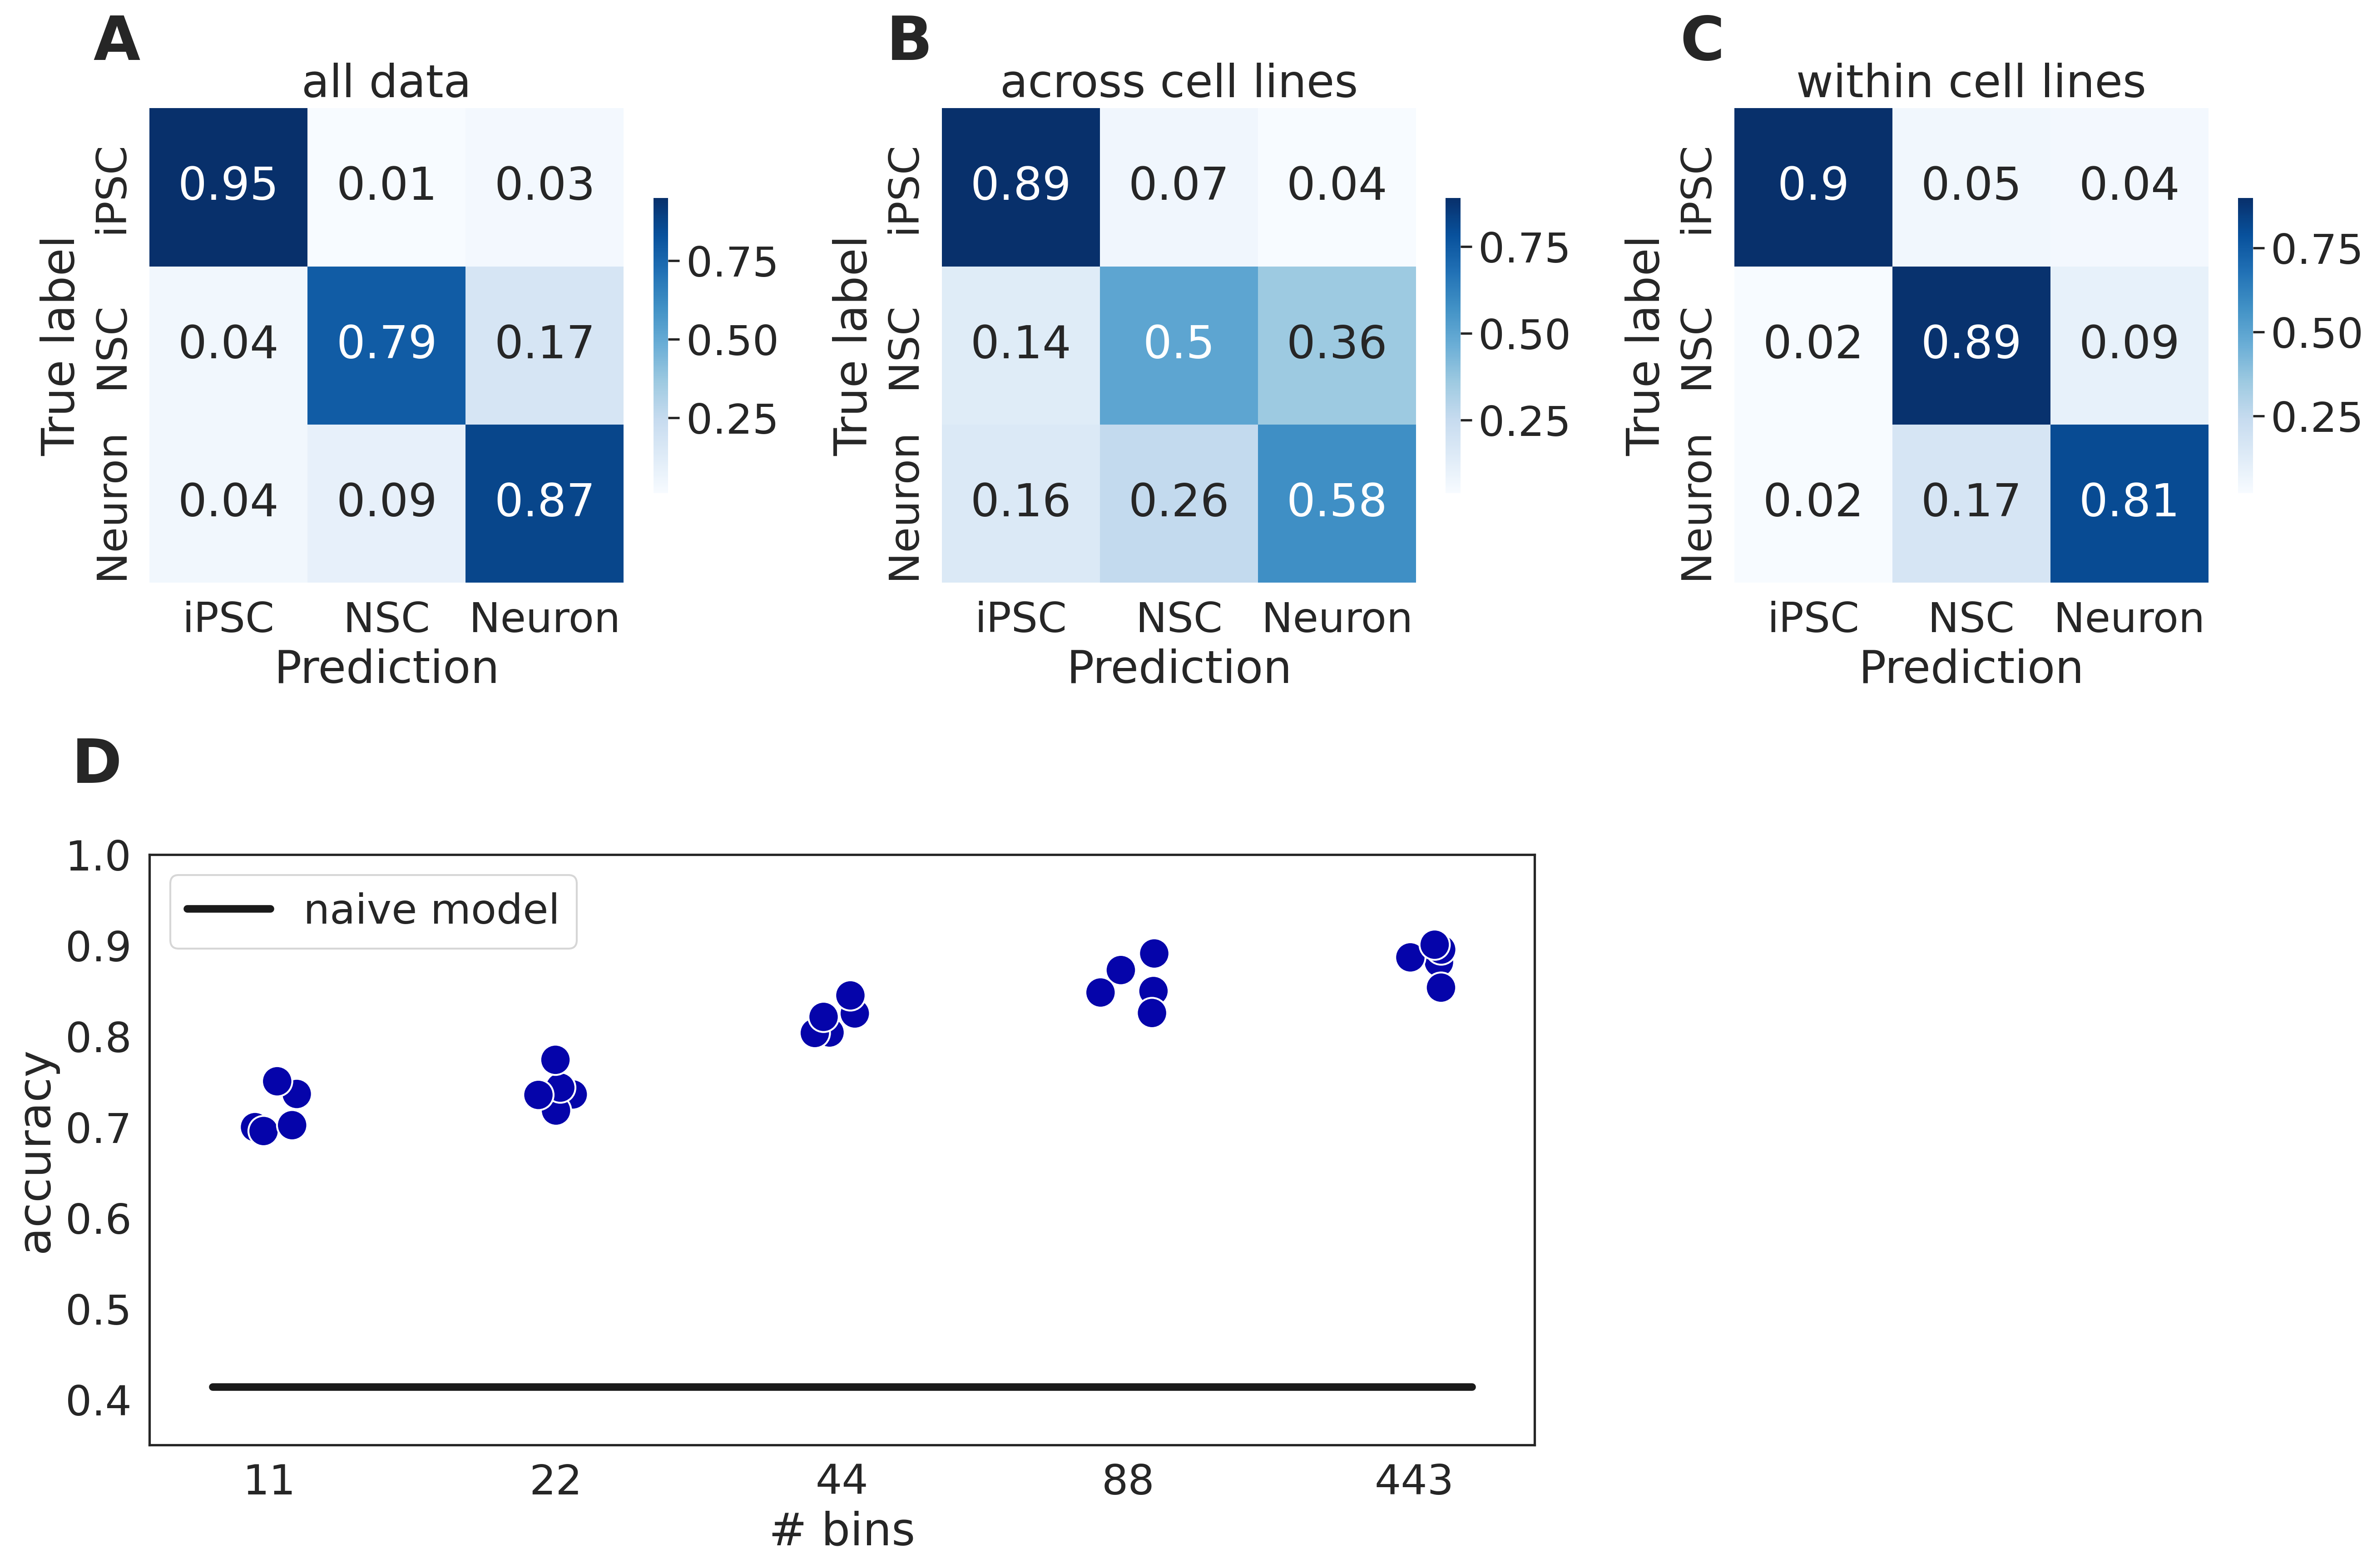

In [54]:
file = open('./results/y_test_all.pkl','rb')
y_test_all = pickle.load(file)
file.close()

file = open('./results/y_pred_all.pkl','rb')
y_pred_all = pickle.load(file)
file.close()

file = open('./results/y_test_across.pkl','rb')
y_test_across = pickle.load(file)
file.close()

file = open('./results/y_pred_across.pkl','rb')
y_pred_across = pickle.load(file)
file.close()

file = open('./results/y_test_within.pkl','rb')
y_test_within = pickle.load(file)
file.close()

file = open('./results/y_pred_within.pkl','rb')
y_pred_within = pickle.load(file)
file.close()

file = open('./results/acc_bin_five.pkl','rb')
acc_bin_five = pickle.load(file)
file.close()

file = open('./results/allNbin_five.pkl','rb')
allNbin_five = pickle.load(file)
file.close()

acc_bin_five_df = pd.DataFrame(acc_bin_five).melt()
acc_bin_five_df['# bins'] = np.repeat(allNbin_five,5)
acc_bin_five_df.drop('variable',axis=1,inplace=True)
acc_bin_five_df.columns = ['accuracy','# bins']


sns.set(font_scale=1.5,style='white')

sns.set(font_scale=2,style='white')

layout = [['A', 'B', 'C'],
     ['D', 'D','E']]

fig,ax = plt.subplot_mosaic(layout,figsize=[18,12],
                            gridspec_kw={'height_ratios': [1,1]} )

panel_label(ax['A'],'A',xpos=-0.02,ypos=1.2)

conf_nn_filter = np.round(confusion_matrix(y_test_all,y_pred_all,labels = [0,1,2],normalize='true'),2)

s = sns.heatmap(conf_nn_filter,xticklabels = ['iPSC','NSC','Neuron'],
            yticklabels = ['iPSC','NSC','Neuron'],cbar_kws={"shrink": 0.5},
           square=True,cmap="Blues",annot=True,ax=ax['A'])

s.set(xlabel='Prediction', ylabel='True label');

ax['A'].set_title('all data')

panel_label(ax['B'],'B',xpos=-0.02,ypos=1.2)

conf_nn_filter = np.round(confusion_matrix(y_test_across,y_pred_across,labels = [0,1,2],normalize='true'),2)

s = sns.heatmap(conf_nn_filter,xticklabels = ['iPSC','NSC','Neuron'],
            yticklabels = ['iPSC','NSC','Neuron'],cbar_kws={"shrink": 0.5},
           square=True,cmap="Blues",annot=True,ax=ax['B'])

s.set(xlabel='Prediction', ylabel='True label');

ax['B'].set_title('across cell lines')


panel_label(ax['C'],'C',xpos=-0.02,ypos=1.2)

conf_nn_filter = np.round(confusion_matrix(y_test_within,y_pred_within,labels = [0,1,2],normalize='true'),2)

s = sns.heatmap(conf_nn_filter,xticklabels = ['iPSC','NSC','Neuron'],
            yticklabels = ['iPSC','NSC','Neuron'],cbar_kws={"shrink": 0.5},
           square=True,cmap="Blues",annot=True,ax=ax['C'])

s.set(xlabel='Prediction', ylabel='True label');

ax['C'].set_title('within cell lines')

panel_label(ax['D'],'D',xpos=-0.02,ypos=1.2)

s = sns.stripplot(data=acc_bin_five_df,x='# bins',y='accuracy',
                       jitter=0.1, palette=[mypalette[0]],ax=ax['D'],s=16,
                          edgecolor="white",linewidth=1)

ax['D'].plot([-0.2,4.2],[base_acc,base_acc],'k-',lw=4,label = 'naive model');
ax['D'].legend()

ax['D'].set_ylim([0.35,1])

ax['E'].axis('off')

# fig.suptitle('Confusion tables')

plt.tight_layout()

fig.savefig('./figures/FigS7.png')

## Create model visualization

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


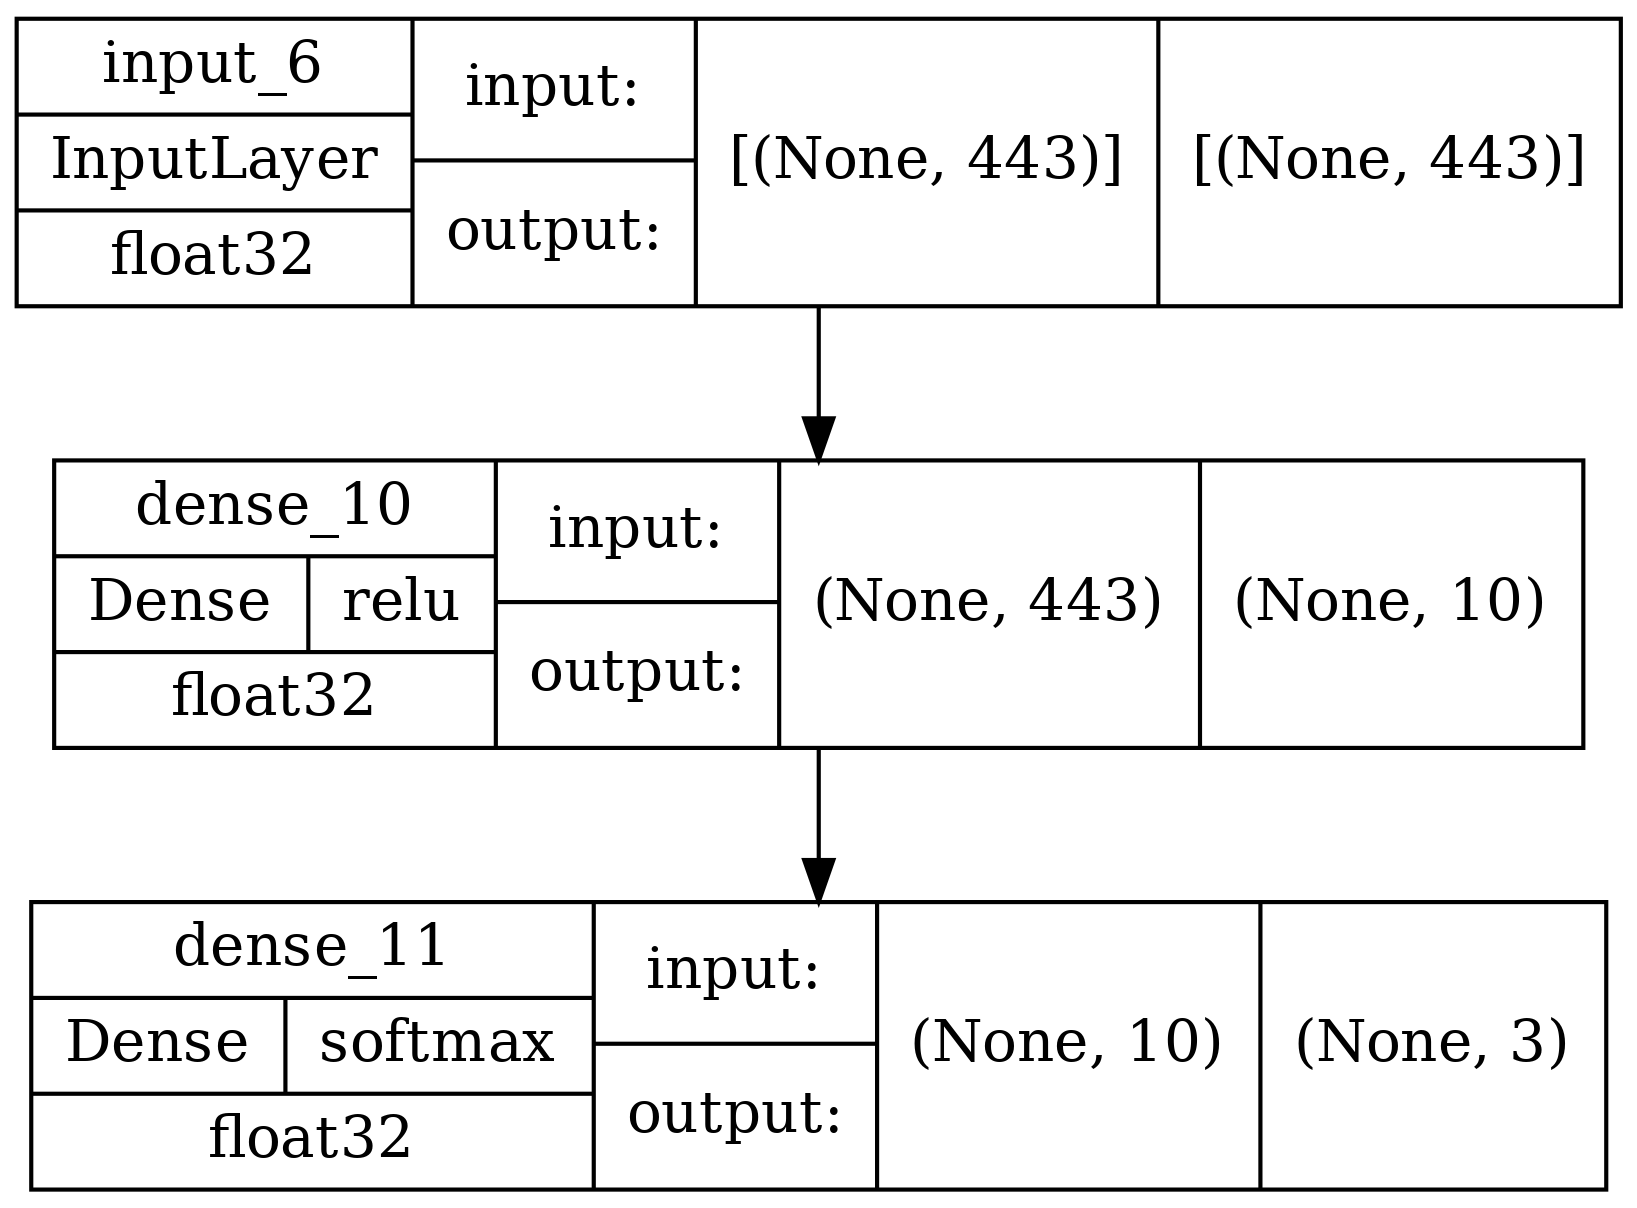

In [9]:
spectra = pd.read_csv('raman_fingerprint_processed.csv',index_col=0)
spectra, spectra_cell,spectra_ctype,meta, meta_cell = split_data(spectra)
y = meta['ctype'].map({'iPSC' : 0 , 'NSC' : 1, 'Neuron' :2}).astype('uint8')
model = train_nn(spectra,y,plot_model=True)

plot_model(
    model,
    to_file='./figures/FigS6_modelA.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=300,
    show_layer_activations=True,
)
# model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


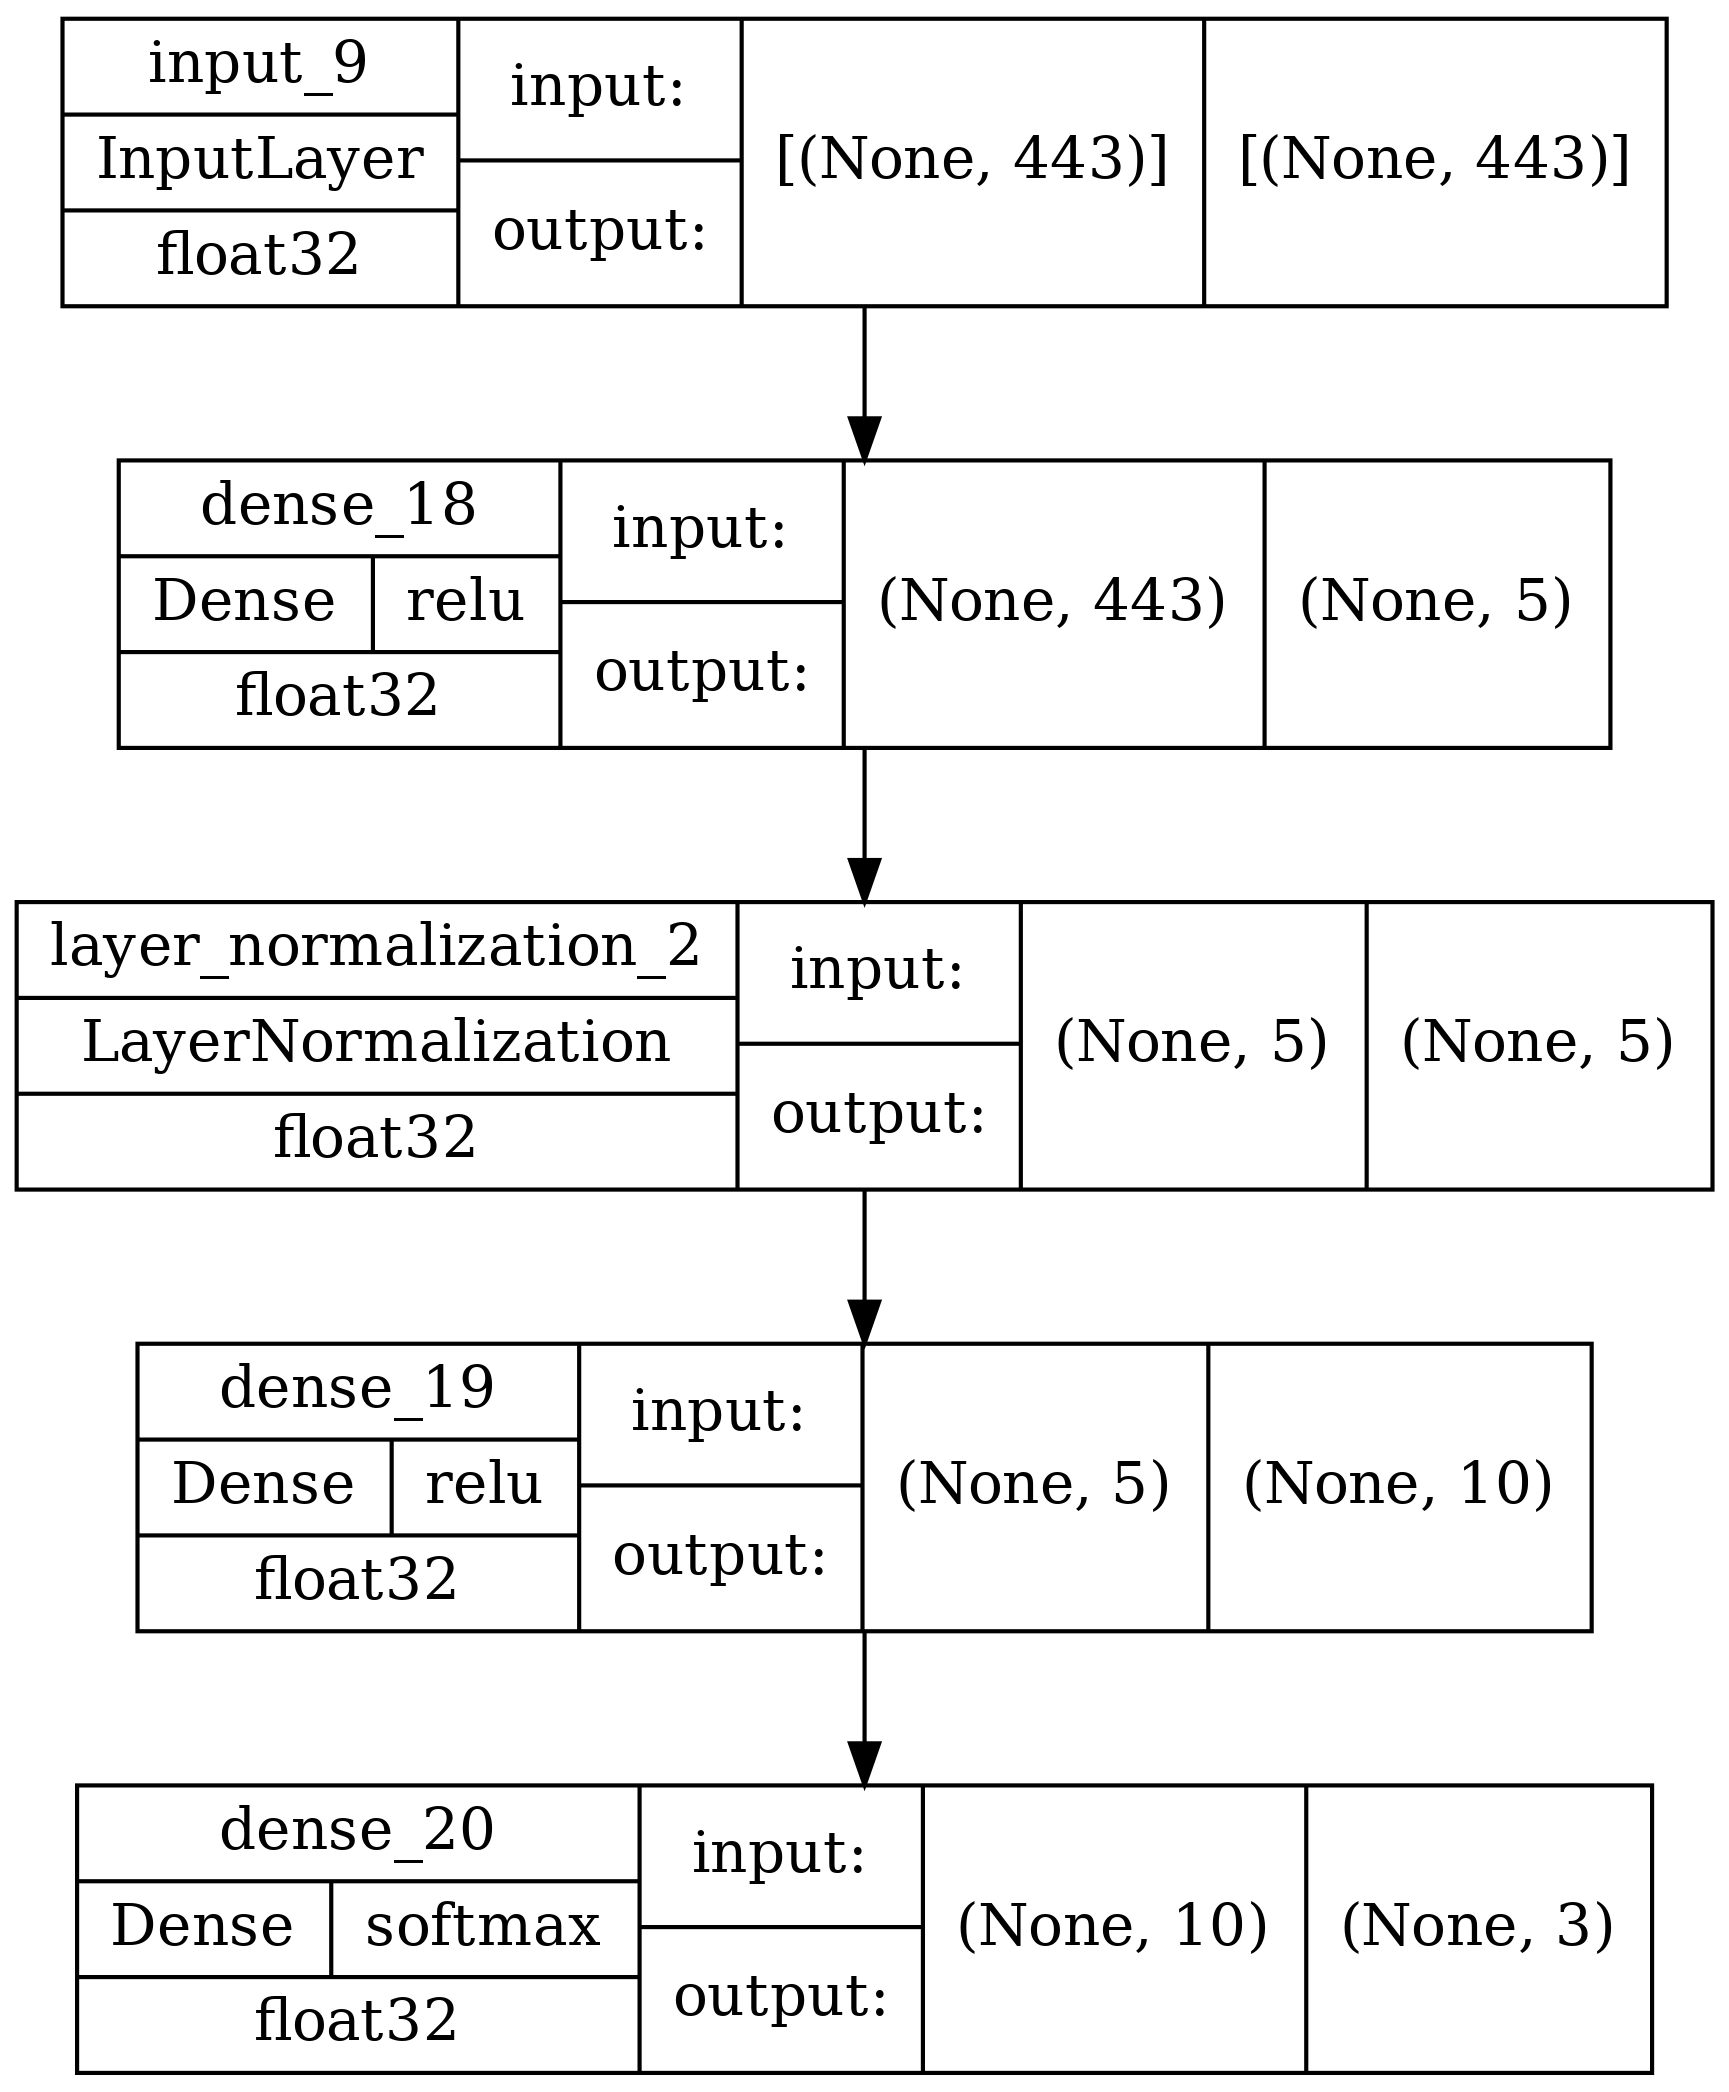

In [12]:
spectra = pd.read_csv('raman_fingerprint_raw.csv',index_col=0)
spectra, spectra_cell,spectra_ctype,meta, meta_cell = split_data(spectra)

X = spectra
y = meta['ctype'].map({'iPSC' : 0 , 'NSC' : 1, 'Neuron' :2}).astype('uint8')

model = train_nn_filter(X,y,Nfilters=5,epochs=200,batch_size=16,plot_model=True)

plot_model(
    model,
    to_file='./figures/FigS6_modelB.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=300,
    show_layer_activations=True,
)
# model.summary()

### Figure S8

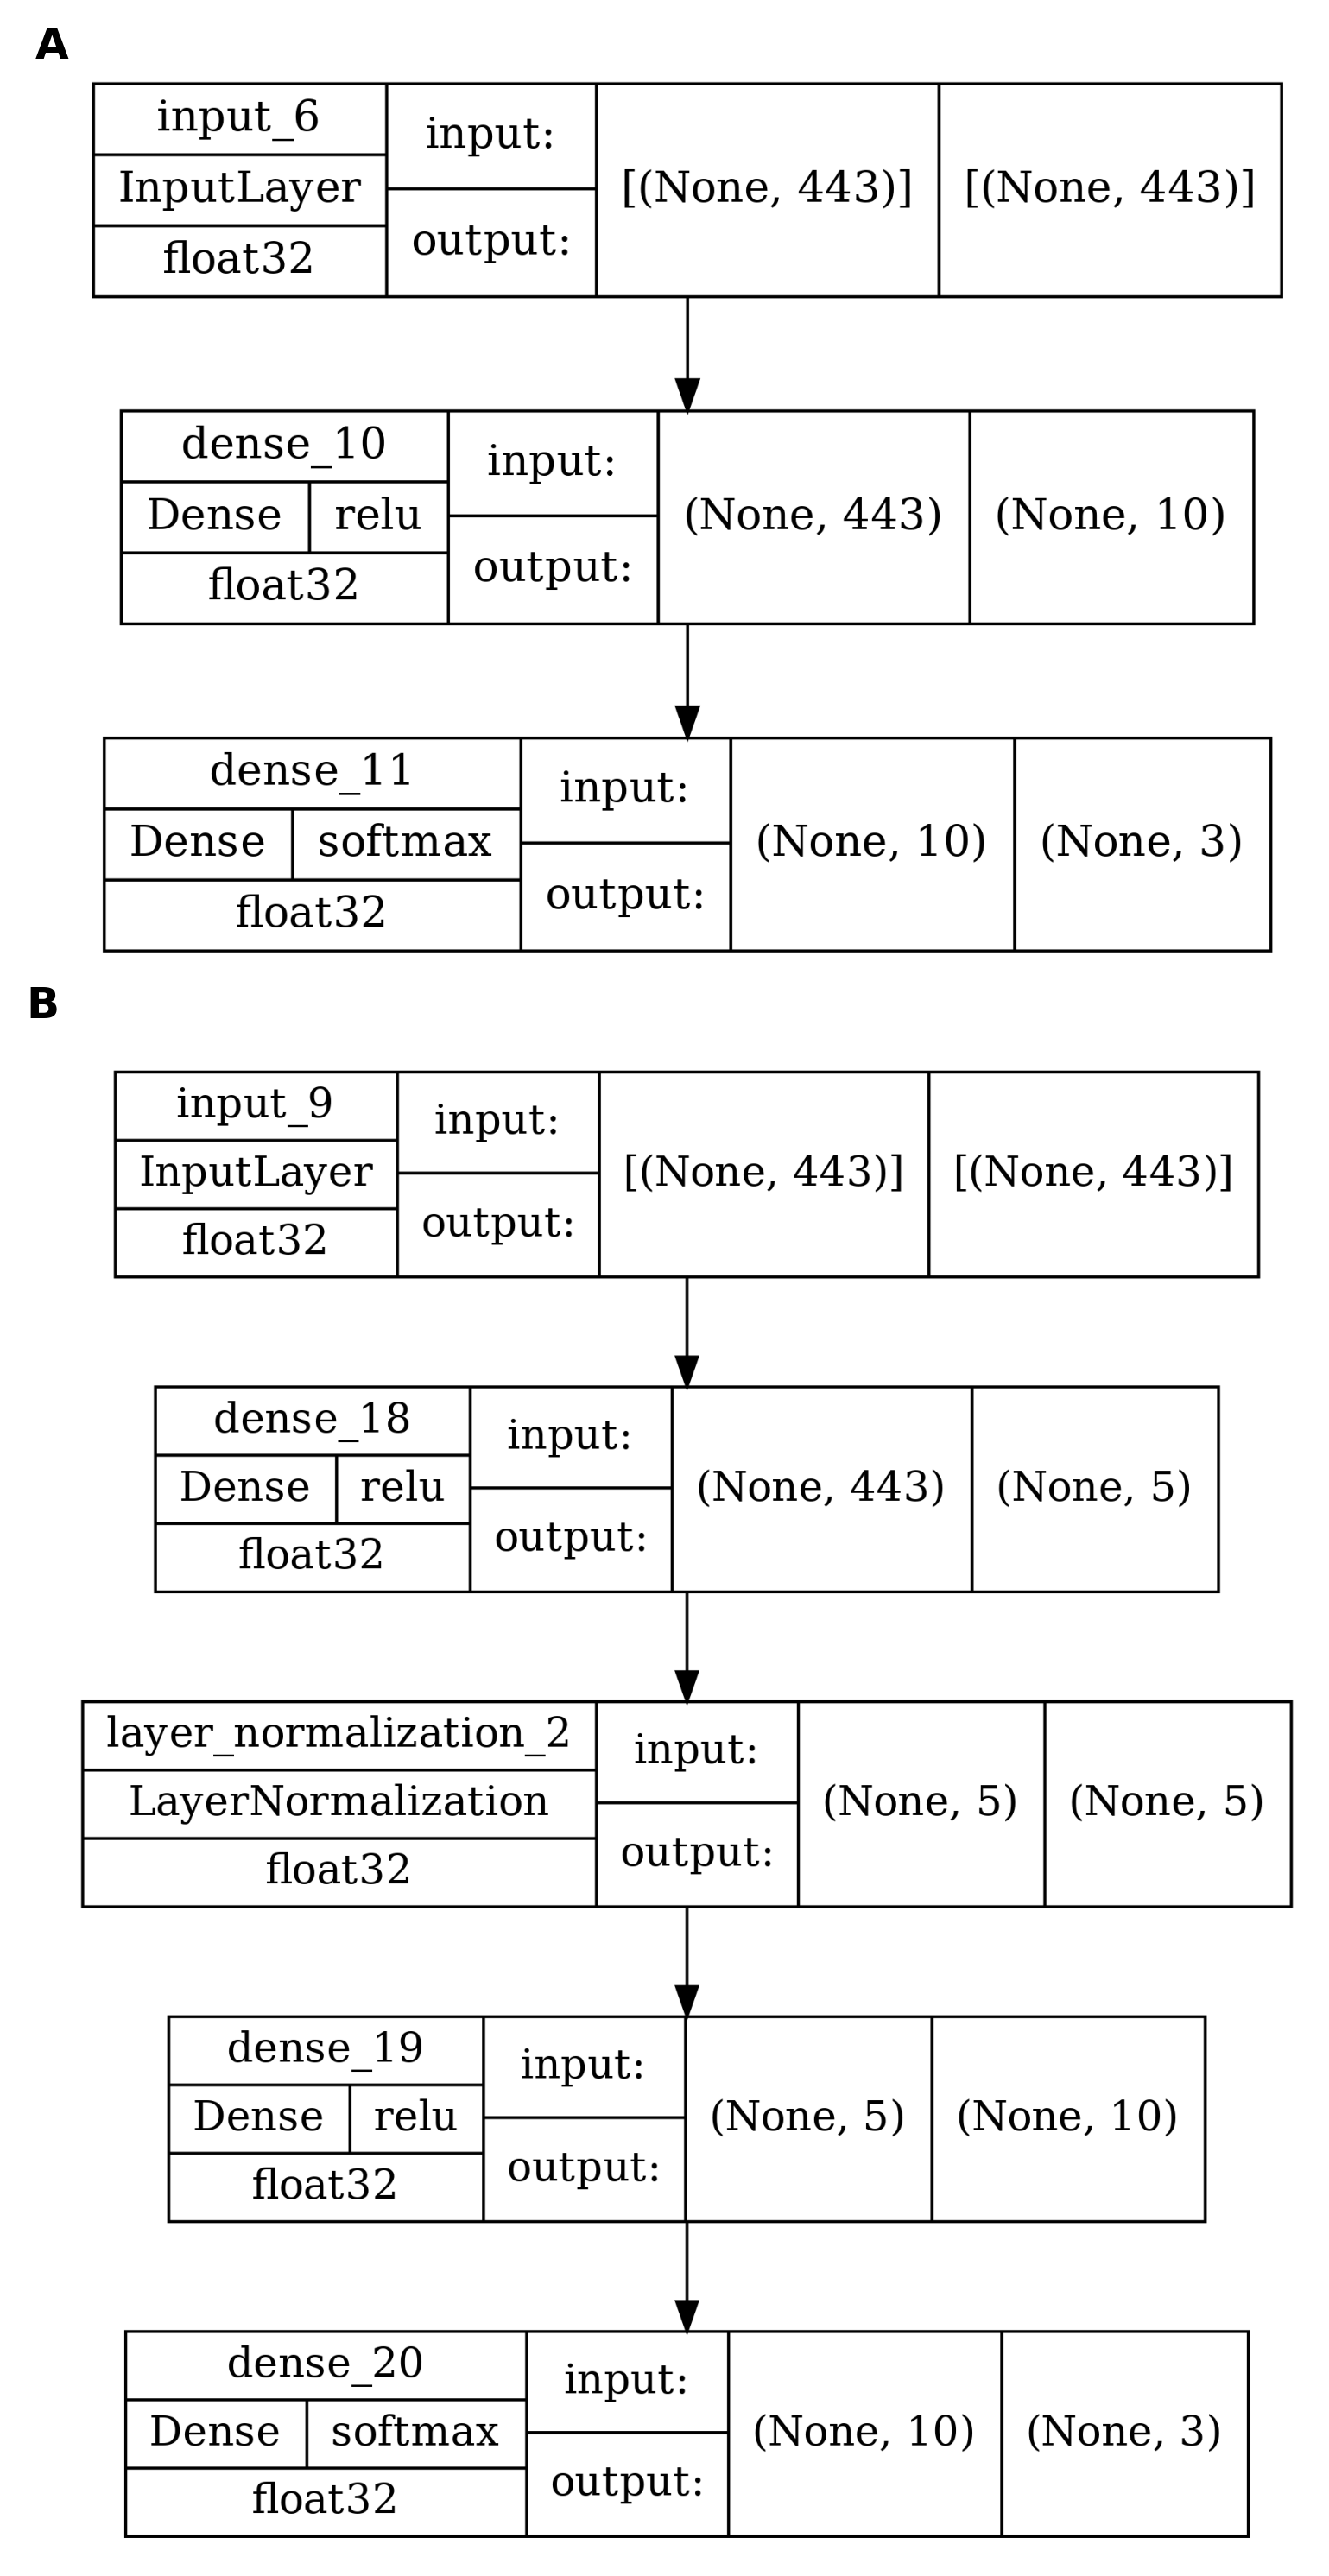

In [29]:
imgA = mpimg.imread('./figures/FigS8_modelA.png')
imgB = mpimg.imread('./figures/FigS8_modelB.png')

fig,ax = plt.subplots(figsize = [10,10],nrows=2,gridspec_kw={'height_ratios': [3, 5]})

panel_label(ax[0],'A',fontsize=12,ypos=1.05)
ax[0].imshow(imgA)
ax[0].axis('off')

panel_label(ax[1],'B',fontsize=12,ypos=1.05)
ax[1].imshow(imgB)
ax[1].axis('off')
plt.tight_layout()
fig.savefig('./figures/FigS8.png')

## Get data statistics

In [62]:
spectra = pd.read_csv('raman_fingerprint_raw.csv',index_col=0)
spectra, spectra_cell,spectra_ctype,meta, meta_cell = split_data(spectra)

In [71]:
# get number of measurements per cell type
stats_df = pd.DataFrame(meta.drop_duplicates().groupby('ctype').size()).T
stats_df.columns.name = None
stats_df = pd.concat([stats_df,pd.DataFrame(meta.groupby('ctype').size()).T])
stats_df.index = ['cells','measurements']
stats_df

iPSC   NSC  Neuron
cells          180   176     180
measurements  3850  2342    3116

Average measurements per cell

In [72]:
stats = pd.DataFrame(meta.groupby(['ctype','cline','rep','date','count']).size())
print(stats.loc[stats.iloc[:,-1] > 0,:].mean())

0    17.365672
dtype: float64


In [83]:
pd.set_option('display.max_rows', None, 'display.max_columns', None)

stats_count = pd.DataFrame(meta.drop_duplicates().groupby(['ctype','cline','rep','date']).size())
stats_count = stats_count.loc[stats_count.iloc[:,-1] > 0,:]

stats_meas = pd.DataFrame(meta.groupby(['ctype','cline','rep','date']).size())
stats_meas = stats_meas.loc[stats_meas.iloc[:,-1] > 0,:]

stats_all = pd.concat([stats_count,stats_meas],axis=1).reset_index()
stats_all.columns = ['cell type', 'cell line','rep','date','cells','measurements']

stats_all.to_csv('./figures/TableS1.csv',index=False)
